In [1]:
import numpy as np
import genesis as gs
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

from quadcopter_control.controller import QuadcopterController
from tqdm import tqdm

[I 05/21/25 09:46:50.854 266647] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [ ]:
# Sim Constants

DT_S = 0.01

DRONE_MASS = 0.027
NEWTON_TO_RPM = 14468.429183500699 / (9.81 * DRONE_MASS / 4)

Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

MIN_THRUST = 0.26477955 / 4 * 0.8
MAX_THRUST = 0.26477955 / 4 * 1.5

In [3]:
# Initialize Genesis

gs.init(backend=gs.gpu, logging_level="error")

viewer_options = gs.options.ViewerOptions(
    camera_pos=(2.5, 0.0, 1.5),
    camera_lookat=(0.0, 0.0, 0.5),
    camera_fov=30,
    max_FPS=600,
)

scene = gs.Scene(
    sim_options=gs.options.SimOptions(
        dt=DT_S,
    ),
    viewer_options=viewer_options,
    show_viewer=True,
)

plane = scene.add_entity(
    gs.morphs.Plane(),
)

drone = scene.add_entity(
    morph=gs.morphs.Drone(
        file="urdf/drones/cf2x.urdf",
        pos=(0.0, 0, 0.02),
    ),
)

scene.build()

In [4]:
def reset():
    drone.set_pos(np.array([0, 0, 0.02]), zero_velocity=True)
    drone.set_quat(np.array([1, 0, 0, 0]), zero_velocity=True)
    drone.zero_all_dofs_velocity()
    scene.step(update_visualizer=False)

In [ ]:
def sim_step(motors):
    # change motor order
    motors = np.array([motors[0], motors[2], motors[3], motors[1]])

    # scale
    motors = motors * NEWTON_TO_RPM

    drone.set_propellels_rpm(motors)
    scene.step()

    position = drone.get_pos().cpu().numpy()
    velocity = drone.get_vel().cpu().numpy()
    attitude = R.from_quat(drone.get_quat().cpu().numpy(), scalar_first=True)
    omega    = drone.get_ang().cpu().numpy()

    omega[0], omega[1], omega[2] = -omega[0], -omega[1], omega[2]

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [6]:
quadcopter_controller = QuadcopterController(
    DT_S,
    DRONE_MASS * 0.99,
    Ixx, Iyy, Izz,
    0.7, 
    5, 5, 5, 
    0.03,
    MIN_THRUST, MAX_THRUST,
)

In [7]:
def tune_controller(
        target={
            "position": np.array([0, 0, 5]),
            "velocity": np.zeros(3),
            "acceleration": np.zeros(3),
            "attitude": R.from_quat([0, 0, 0, 1]),
        },
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=500,
):
    reset()
    scene.step()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    attitudes = []

    state = sim_step([0, 0, 0, 0])

    t = 0
    for _ in tqdm(range(n_episodes)):

        motors = quadcopter_controller.run_control(
            target['position'],
            target['velocity'],
            target['acceleration'],
            target['attitude'],
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'])
        positions.append(state['position'])
        times.append(t)
        state = sim_step(motors)

        t += DT_S

    return (
        np.array(times),
        np.array(positions),
        np.array(attitudes),
    )

In [8]:
reset()
target = {
    "position": np.array([3, 10, 10]),
    "velocity": np.zeros(3),
    "acceleration": np.zeros(3),
    "attitude": R.from_quat([0, 0, 0, 1]),
}

In [9]:
(times, positions, attitudes) = tune_controller(
    kp_pqr=np.array([25, 25, 5]),
    ki_pos_z=2,
    kp_pos_z=6,
    kp_vel_z=12,
    kp_pos_xy=8.0,
    kp_vel_xy=8.0,
    kp_yaw=1.0,
    kp_bank=2.0,
    n_episodes=5000,
    target=target
)

[-0. -0.  0.]


  0%|          | 2/5000 [00:00<07:39, 10.87it/s]

[ 0.5935994  -0.5935994  -0.02968623]
[-1.5948144   0.75931513 -0.01389364]
[ 0.35930705 -0.01545374 -0.16760235]
[ 0.69819057 -0.66867936 -0.15737484]
[ 0.70618165 -0.69228655 -0.15676376]
[ 0.69449824 -0.67958206 -0.15622318]


  1%|          | 50/5000 [00:00<00:31, 158.32it/s]

[ 0.68185115 -0.66515565 -0.15566304]
[ 0.6694081  -0.6509816  -0.15508634]
[ 0.6572367  -0.63715476 -0.15449536]
[ 0.6453304  -0.6236717  -0.15389088]
[ 0.63368344 -0.6105181  -0.15327448]
[ 0.6222846  -0.59768385 -0.15264748]
[ 0.6111273 -0.5851564 -0.1520113]
[ 0.6002028  -0.5729245  -0.15136614]
[ 0.5895046  -0.5609796  -0.15071365]
[ 0.5790242  -0.54931134 -0.15005411]
[ 0.5687575  -0.53791046 -0.14938873]
[ 0.5586954  -0.52677    -0.14871812]
[ 0.54883367 -0.51587915 -0.14804311]
[ 0.5391678  -0.5052311  -0.14736369]
[ 0.52968997 -0.49481905 -0.14668141]
[ 0.5203954  -0.48463547 -0.14599583]
[ 0.51128155 -0.47467458 -0.14530805]
[ 0.50234336 -0.46492884 -0.14461823]
[ 0.49357283 -0.4553908  -0.14392677]
[ 0.48496705 -0.44605756 -0.1432346 ]
[ 0.4765261  -0.43692178 -0.14254156]
[ 0.46824148 -0.42797667 -0.14184746]
[ 0.46010983 -0.4192223  -0.1411542 ]
[ 0.45213032 -0.410649   -0.1404605 ]
[ 0.44429833 -0.40224922 -0.13976641]
[ 0.43661132 -0.39402646 -0.13907295]
[ 0.429057   -0

  2%|▏         | 99/5000 [00:00<00:23, 204.54it/s]

[ 0.32469848 -0.2757537  -0.12403988]
[ 0.3802771 -0.3282638 -0.1223843]
[ 0.42993024 -0.37060526 -0.11978085]
[ 0.46980935 -0.40303728 -0.11721639]
[ 0.50054383 -0.42722434 -0.11492459]
[ 0.52335936 -0.44454265 -0.11293811]
[ 0.5395022  -0.45625713 -0.11125337]
[ 0.5501346  -0.46341208 -0.10983878]
[ 0.5562589  -0.4668822  -0.10865638]
[ 0.558778   -0.4674603  -0.10767904]
[ 0.55841607 -0.46577266 -0.10687688]
[ 0.5557776  -0.46231633 -0.10622284]
[ 0.55138075 -0.4575164  -0.1056918 ]
[ 0.54564327 -0.45166588 -0.10524652]
[ 0.53889596 -0.44508305 -0.10489023]
[ 0.5313611  -0.43792775 -0.10459737]
[ 0.52326465 -0.43037412 -0.10436497]
[ 0.5147778  -0.42254612 -0.10416941]
[ 0.506052   -0.41457734 -0.10400491]
[ 0.49715182 -0.40650144 -0.10387264]
[ 0.48617783 -0.37975478 -0.09802523]
[ 0.47020337 -0.3127284  -0.07973175]
[ 0.4511116  -0.23083837 -0.05699463]
[ 0.4304174  -0.14391714 -0.03270141]
[ 0.4090996  -0.05580246 -0.00788289]
[0.38771152 0.03196776 0.01710263]
[0.36653274 0.1187

  3%|▎         | 151/5000 [00:00<00:20, 232.72it/s]

[0.14227358 1.3013197  0.42630526]
[0.14735053 1.2733092  0.41395748]
[0.1520388  1.2455378  0.40159625]
[0.15627751 1.2182913  0.38934886]
[0.16001464 1.1916718  0.3772635 ]
[0.16325648 1.1657125  0.36537594]
[0.16608498 1.140407   0.35369307]
[0.16851178 1.1157469  0.34223047]
[0.17053649 1.0917186  0.3310004 ]
[0.17221862 1.0683178  0.32000643]
[0.17355007 1.0454937  0.30923456]
[0.17454723 1.0232317  0.29868025]
[0.17526689 1.0015403  0.28836155]
[0.17576498 0.9803439  0.27824947]
[0.1759898  0.95965403 0.26837033]
[0.17597114 0.93947256 0.25871012]
[0.17573199 0.91982    0.24929094]
[0.17530844 0.90058976 0.24007255]
[0.17463854 0.88181245 0.2310765 ]
[0.17385998 0.8634475  0.22227369]
[0.17287792 0.8455425  0.21370305]
[0.17178938 0.8280562  0.20532939]
[0.1705117  0.8109324  0.19714807]
[0.16910933 0.79419756 0.18916915]
[0.1676257  0.77782077 0.18138419]
[0.16601592 0.76185983 0.17380925]
[0.16424738 0.7462292  0.16641873]
[0.162397   0.73093295 0.15920825]
[0.160526   0.715947

  4%|▎         | 176/5000 [00:00<00:20, 237.58it/s]

[0.10436853 0.4468177  0.03350437]
[0.10176477 0.43782112 0.02992754]
[0.09919858 0.4289943  0.02644713]
[0.09669835 0.42036974 0.0230938 ]
[0.09410815 0.4119076  0.01984213]
[0.09161869 0.40362614 0.01668234]
[0.08909751 0.39551136 0.01362237]
[0.08665441 0.38757166 0.01066615]
[0.08413391 0.37978563 0.00781122]
[0.08168598 0.37218073 0.0050444 ]
[0.07931283 0.3647295  0.00235689]
[ 7.6905809e-02  3.5742742e-01 -2.3102760e-04]
[ 0.07453905  0.35026592 -0.00273955]
[ 0.07220786  0.34326458 -0.00516072]
[ 0.06986739  0.3364093  -0.00749394]
[-0.03052125  0.31211352  0.02141258]
[-0.18494755  0.2786422   0.06816144]
[-0.355796    0.24304251  0.12111935]
[-0.52968484  0.20795982  0.17610145]
[-0.7013351   0.17458275  0.23153707]
[-0.86878216  0.14348777  0.28684688]
[-1.0311571   0.1150182   0.34178436]
[-1.1879554   0.08945097  0.39620227]
[-1.3389522   0.06699136  0.4499958 ]
[-1.4839668   0.04782222  0.5030449 ]
[-1.6227499   0.03207324  0.5552233 ]
[-1.7553177   0.01980484  0.60638076

  5%|▍         | 226/5000 [00:01<00:20, 234.18it/s]

[-1.1607103  -0.43814194  0.28336954]
[-1.1347466  -0.483238    0.27027148]
[-1.1094953  -0.5274617   0.25822437]
[-1.0849435  -0.570722    0.24717729]
[-1.0609958  -0.6129339   0.23706761]
[-1.0376428  -0.6540197   0.22785214]
[-1.01487    -0.69390804  0.21948633]
[-0.99265915 -0.7325347   0.2119214 ]
[-0.9709678  -0.7698402   0.20510645]
[-0.94988173 -0.8057695   0.19900984]
[-0.92930627 -0.84027797  0.1935653 ]
[-0.909213   -0.8733237   0.18872488]
[-0.88965434 -0.90486825  0.18445346]
[-0.87060964 -0.9348802   0.1807005 ]
[-0.8520611  -0.96333236  0.17741619]
[-0.83397293 -0.99020237  0.1745553 ]
[-0.8163933  -1.0154727   0.17208026]
[-0.79925543 -1.0391217   0.16994113]
[-0.78262603 -1.0611465   0.16810521]
[-0.76642334 -1.0815351   0.16651842]
[-0.7507564  -1.1002814   0.16515811]
[-0.735479   -1.1173854   0.16396087]
[-0.72065914 -1.1328421   0.16290209]
[-0.70623374 -1.1466589   0.16193962]
[-0.69220877 -1.1588347   0.16104014]
[-0.6786324  -1.1693811   0.16017625]
[-0.6654309 

  6%|▌         | 277/5000 [00:01<00:19, 240.05it/s]

[-0.45418462 -0.941755    0.07555185]
[-0.4457935  -0.92282987  0.07013822]
[-0.43744135 -0.9043391   0.06486474]
[-0.42919424 -0.88626796  0.05972849]
[-0.4209718  -0.8686021   0.05472739]
[-0.41289353 -0.8513294   0.04984775]
[-0.40487516 -0.8344399   0.04510082]
[-0.39690837 -0.8179143   0.04048216]
[-0.3890549  -0.8017457   0.03598179]
[-0.38127333 -0.78592396  0.03160077]
[-0.37316322 -0.7635484   0.02489595]
[-0.36499053 -0.73494124  0.01588577]
[-0.3570728  -0.7033611   0.00568505]
[-0.34936905 -0.67015785 -0.00521737]
[-0.34179854 -0.63590515 -0.016601  ]
[-0.33431965 -0.60086614 -0.02837192]
[-0.32690087 -0.5651827  -0.0404723 ]
[-0.31952155 -0.52894676 -0.05287366]
[-0.31226236 -0.49224067 -0.06555516]
[-0.30505344 -0.4551294  -0.07848571]
[-0.29791838 -0.41767967 -0.09164821]
[-0.2908316  -0.37996164 -0.10501628]
[-0.28392977 -0.3420493  -0.11858166]
[-0.27709937 -0.30400494 -0.13230354]
[-0.27041528 -0.2659037  -0.14616513]
[-0.26389214 -0.22781508 -0.1601414 ]
[-0.25746942

  7%|▋         | 329/5000 [00:01<00:19, 240.70it/s]

[-0.17278114  0.58226335 -0.4804392 ]
[-0.17256355  0.5956022  -0.485429  ]
[-0.17242615  0.6076391  -0.48977184]
[-0.17235719  0.6183715  -0.4934585 ]
[-0.17234059  0.6278002  -0.49647912]
[-0.17232388  0.6359297  -0.49882966]
[-0.17230599  0.64276385 -0.5005095 ]
[-0.17226171  0.6483118  -0.5015112 ]
[-0.17218    0.6525824 -0.5018355]
[-0.1720191   0.65558535 -0.501482  ]
[-0.17177413  0.6573335  -0.5004568 ]
[-0.17142847  0.65784353 -0.49876055]
[-0.17093123  0.6571276  -0.49640113]
[-0.17027499  0.65520597 -0.49338663]
[-0.16945417  0.65209866 -0.48972678]
[-0.16844638  0.6478261  -0.48543197]
[-0.16723162  0.6424093  -0.48051384]
[-0.16580579  0.63587123 -0.47498542]
[-0.16412438  0.6282339  -0.4688593 ]
[-0.16220827  0.6195268  -0.46215522]
[-0.16002636  0.609777   -0.45488974]
[-0.15757023  0.59901077 -0.447077  ]
[-0.15484495  0.58725697 -0.43873978]
[-0.15182655  0.5745465  -0.42989683]
[-0.1485133   0.56091005 -0.4205708 ]
[-0.14491531  0.54638386 -0.41077977]
[-0.1410263   0

  8%|▊         | 382/5000 [00:01<00:18, 251.94it/s]

[ 0.00790116  0.0271408  -0.09675078]
[ 0.0151258   0.00280538 -0.08282329]
[ 0.02222356 -0.02138717 -0.06900878]
[ 0.02917694 -0.04539746 -0.05532552]
[ 0.03596056 -0.06918568 -0.0417923 ]
[ 0.04254781 -0.09271284 -0.02842657]
[ 0.04892774 -0.11594335 -0.01524612]
[ 0.05507499 -0.1388398  -0.00226795]
[ 0.06097935 -0.16136661  0.01049042]
[ 0.06661457 -0.18348917  0.02301341]
[ 0.07197192 -0.20517398  0.03528407]
[ 0.07703857 -0.22638917  0.04728691]
[ 0.08180121 -0.24710198  0.05900552]
[ 0.0862488  -0.2672833   0.07042549]
[ 0.09037324 -0.28690365  0.08153144]
[ 0.09416962 -0.30593526  0.092309  ]
[ 0.09762973 -0.32435066  0.10274407]
[ 0.10074762 -0.34212533  0.11282331]
[ 0.10352521 -0.35923424  0.12253312]
[ 0.10595606 -0.37565452  0.13186127]
[ 0.10804258 -0.3913657   0.14079581]
[ 0.10978622 -0.4063464   0.14932527]
[ 0.11118858 -0.4205786   0.15743874]
[ 0.11225548 -0.4340437   0.16512567]
[ 0.11299005 -0.44672555  0.17237656]
[ 0.11340076 -0.45860934  0.17918265]
[ 0.11349197

  9%|▊         | 433/5000 [00:01<00:19, 237.49it/s]

[ 0.05783117 -0.49721295  0.20458029]
[ 0.05386034 -0.48891625  0.200172  ]
[ 0.04985919 -0.47987938  0.19536608]
[ 0.04584105 -0.47011927  0.19017367]
[ 0.0418154  -0.45965844  0.18460895]
[ 0.03779419 -0.4485173   0.17868504]
[ 0.03378049 -0.43671685  0.1724152 ]
[ 0.02978278 -0.4242836   0.16581522]
[ 0.02581411 -0.41124165  0.15889972]
[ 0.02187447 -0.39761567  0.15168457]
[ 0.01797058 -0.3834345   0.14418644]
[ 0.01411563 -0.36872587  0.13642162]
[ 0.01030813 -0.35351703  0.12840652]
[ 0.00655592 -0.337839    0.12015871]
[ 0.00285333 -0.3217223   0.11169612]
[-0.00078253 -0.30519965  0.10303769]
[-0.00435494 -0.28830114  0.09420071]
[-0.0078593  -0.2710602   0.08520377]
[-0.01129286 -0.25350976  0.07606552]
[-0.01465493 -0.2356847   0.06680435]
[-0.01794647 -0.2176188   0.05743967]
[-0.02116866 -0.19934729  0.04799016]
[-0.01016361 -0.18021029  0.03978947]
[ 0.07192789 -0.15569755  0.03728474]
[ 0.17736016 -0.12053794  0.03207251]
[ 0.28782797 -0.07842814  0.02400102]
[ 0.39725527

 10%|▉         | 484/5000 [00:02<00:18, 241.74it/s]

[ 1.4840137   0.47505426 -0.07496176]
[ 1.4508209   0.46525204 -0.07348998]
[ 1.418843    0.4552921  -0.07193214]
[ 1.3879621   0.4452306  -0.07031902]
[ 1.3581036   0.4350729  -0.06866642]
[ 1.3292065   0.42480984 -0.06698712]
[ 1.3012297   0.41443017 -0.06529088]
[ 1.2741361   0.40392497 -0.06358828]
[ 1.2478786   0.3932875  -0.06188973]
[ 1.222431    0.38251227 -0.06020431]
[ 1.1977595   0.37159714 -0.05854151]
[ 1.1738311   0.3605408  -0.05691056]
[ 1.1506156   0.34934276 -0.05531902]
[ 1.1280777   0.33800605 -0.05377613]
[ 1.1061935   0.32653108 -0.0522885 ]
[ 1.0849358   0.31492203 -0.05086372]
[ 1.0642776   0.30318373 -0.04950732]
[ 1.0441948   0.29132158 -0.04822548]
[ 1.0246606   0.27934268 -0.04702324]
[ 1.0056556   0.26725376 -0.04590563]
[ 0.9871589   0.25506318 -0.04487563]
[ 0.96915     0.24278077 -0.04393767]
[ 0.9516056   0.23041615 -0.04309441]
[ 0.9345061   0.21797845 -0.04234871]
[ 0.9178348   0.20547993 -0.0417015 ]
[ 0.9015761   0.19293094 -0.04115463]
[ 0.88570714

 11%|█         | 533/5000 [00:02<00:19, 233.66it/s]

[ 0.60936356 -0.07902052 -0.05219964]
[ 0.5991574  -0.08875    -0.05328685]
[ 0.58909094 -0.09819888 -0.05437558]
[ 0.579157   -0.10735534 -0.05545842]
[ 0.56935436 -0.11620955 -0.05652931]
[ 0.5596765  -0.12475135 -0.05758131]
[ 0.5501172  -0.13297103 -0.05860747]
[ 0.5406728  -0.14085957 -0.05960089]
[ 0.53133416 -0.14840946 -0.06055535]
[ 0.5220986  -0.1556125  -0.06146388]
[ 0.51296467 -0.16246161 -0.06232065]
[ 0.5039259  -0.16894907 -0.0631185 ]
[ 0.49497867 -0.17507006 -0.06385157]
[ 0.48611733 -0.18081819 -0.06451409]
[ 0.47734112 -0.18618932 -0.06510078]
[ 0.46864468 -0.19117858 -0.06560522]
[ 0.46002528 -0.19578263 -0.06602263]
[ 0.4514818  -0.1999976  -0.06634807]
[ 0.44300827 -0.20382136 -0.06657614]
[ 0.43460155 -0.2072528  -0.06670243]
[ 0.42626038 -0.21028984 -0.06672303]
[ 0.4179833  -0.21293265 -0.06663394]
[ 0.40976647 -0.21518038 -0.0664309 ]
[ 0.40160862 -0.21703431 -0.06611112]
[ 0.39350885 -0.21849513 -0.06567122]
[ 0.38546535 -0.21956488 -0.06510818]
[ 0.37747437

 12%|█▏        | 581/5000 [00:02<00:18, 235.58it/s]

[ 0.2216466  -0.15491614 -0.02043104]
[ 0.21486762 -0.1487389  -0.01706564]
[ 0.20816171 -0.14236742 -0.01361083]
[ 0.20153205 -0.13581458 -0.01007143]
[ 0.19498071 -0.12909272 -0.0064526 ]
[ 0.18851034 -0.12221631 -0.0027599 ]
[ 0.18212502 -0.11519846  0.00100093]
[ 0.17582795 -0.10805228  0.00482448]
[ 0.16962177 -0.10079211  0.00870478]
[ 0.16351004 -0.09343075  0.01263602]
[ 0.15749677 -0.0859832   0.016612  ]
[ 0.15158372 -0.07846199  0.02062673]
[ 0.14577484 -0.07088252  0.02467349]
[ 0.14007245 -0.06325784  0.02874612]
[ 0.13448046 -0.0556019   0.03283808]
[ 0.12900183 -0.04792926  0.03694253]
[ 0.12363937 -0.04025314  0.04105312]
[ 0.11839632 -0.0325874   0.0451633 ]
[ 0.11327542 -0.02494594  0.04926626]
[ 0.10827876 -0.01734208  0.05335522]
[ 0.10340966 -0.00978917  0.05742398]
[ 0.09866887 -0.00229988  0.06146571]
[0.09406008 0.00511145 0.06547371]
[0.08958507 0.01243315 0.06944148]
[0.05951294 0.02023076 0.07222176]
[-0.0094744   0.02464264  0.07110494]
[-0.09056208  0.02127

 13%|█▎        | 636/5000 [00:02<00:17, 253.98it/s]

[-1.4380708  -0.07529739 -0.04433756]
[-1.4708992  -0.07018629 -0.04426286]
[-1.5011343  -0.06433806 -0.04392808]
[-1.528795   -0.05778056 -0.0433626 ]
[-1.5412996  -0.05072644 -0.04181517]
[-1.5246167  -0.04132795 -0.0379936 ]
[-1.4978971  -0.0262821  -0.03256258]
[-1.4688576  -0.00750524 -0.02654725]
[-1.4400816   0.01293957 -0.02057208]
[-1.4121978   0.03379515 -0.01491693]
[-1.3852241   0.05445009 -0.00967591]
[-1.3590493   0.07464948 -0.00486428]
[-1.3335713e+00  9.4301179e-02 -4.6999753e-04]
[-1.3087178   0.11337236  0.00352722]
[-1.2844396   0.13185163  0.00714782]
[-1.2606993   0.14972909  0.01041228]
[-1.2374659   0.16699627  0.01334072]
[-1.2147102   0.18364461  0.01595284]
[-1.1924068   0.19966403  0.01826749]
[-1.1705333   0.21504518  0.0203044 ]
[-1.149065    0.22977866  0.02208156]
[-1.127982    0.24385604  0.023618  ]
[-1.1072642   0.2572676   0.02493281]
[-1.0868931   0.27000684  0.02604394]
[-1.0668514   0.28206638  0.02696897]
[-1.047124    0.29343975  0.02772601]
[-1

 14%|█▍        | 691/5000 [00:03<00:16, 261.00it/s]

[-0.55469906  0.31574222  0.04455122]
[-0.5407985   0.30702904  0.04661712]
[-0.52704597  0.29785326  0.04883701]
[-0.51344347  0.2882357   0.0512106 ]
[-0.49999213  0.27819568  0.05373731]
[-0.48669553  0.267755    0.05641589]
[-0.4735566   0.25693586  0.05924419]
[-0.46057776  0.24575898  0.06222036]
[-0.4477614   0.234247    0.06534128]
[-0.43511295  0.22242343  0.06860325]
[-0.40723473  0.20986092  0.07070899]
[-0.3564964   0.19855966  0.07015251]
[-0.29789782  0.1908809   0.06746545]
[-0.23708457  0.18549527  0.06364814]
[-0.17591716  0.18104662  0.05936911]
[-0.11493091  0.17673957  0.05497271]
[-0.05428252  0.17219552  0.05061607]
[0.00594861 0.16725734 0.04636732]
[0.06567548 0.16186653 0.04225921]
[0.12480182 0.15600319 0.0383103 ]
[0.18321979 0.14966004 0.03453613]
[0.24082059 0.1428384  0.03094843]
[0.29749578 0.13553715 0.02755904]
[0.3531412  0.12776074 0.02437763]
[0.40765682 0.11951455 0.02141229]
[0.46094686 0.11080407 0.01866987]
[0.5129215  0.10163773 0.01615547]
[0.5

 15%|█▍        | 745/5000 [00:03<00:16, 259.10it/s]

[ 1.2084892 -0.269906   0.02101  ]
[ 1.1869265  -0.28681695  0.02403844]
[ 1.1650698  -0.30399442  0.02682752]
[ 1.1434699  -0.32088447  0.02931564]
[ 1.1222507  -0.33720338  0.03150004]
[ 1.1014174  -0.3528216   0.03339767]
[ 1.080946   -0.3676808   0.03503036]
[ 1.0608152  -0.3817531   0.03642036]
[ 1.0410074  -0.39502317  0.03758951]
[ 1.0215057  -0.40747947  0.03855855]
[ 1.0022978 -0.419114   0.0393489]
[ 0.9833725  -0.4299184   0.03998119]
[ 0.9647186  -0.43988714  0.04047554]
[ 0.94632715 -0.44901425  0.04085117]
[ 0.9281896  -0.4572953   0.04112796]
[ 0.9102945  -0.46472716  0.04132513]
[ 0.89263564 -0.47130758  0.04146063]
[ 0.87520534 -0.47703654  0.04155272]
[ 0.8579978  -0.4819144   0.04161851]
[ 0.8410047  -0.48594278  0.04167514]
[ 0.82421976 -0.48912364  0.04173847]
[ 0.807637   -0.49146092  0.04182426]
[ 0.79125184 -0.49296075  0.04194755]
[ 0.7750584  -0.4936282   0.04212291]
[ 0.7590529  -0.49347132  0.0423632 ]
[ 0.7432286  -0.492497    0.04268222]
[ 0.7275839  -0.49

 16%|█▌        | 798/5000 [00:03<00:16, 254.03it/s]

[-0.37083164 -0.27950543  0.01968068]
[-0.41038933 -0.2630392   0.01915311]
[-0.44895232 -0.24609053  0.01870819]
[-0.4864582 -0.2286875  0.0183477]
[-0.5228495  -0.21086052  0.01807213]
[-0.5580692  -0.1926388   0.01788221]
[-0.59206766 -0.17405331  0.01777745]
[-0.62479645 -0.15513563  0.01775729]
[-0.65620995 -0.13591787  0.01782016]
[-0.6862685  -0.11643162  0.01796442]
[-0.71493673 -0.09670968  0.01818755]
[-0.7421799  -0.07678539  0.01848695]
[-0.76796734 -0.05669166  0.0188593 ]
[-0.7922736  -0.03646109  0.01930107]
[-0.81507546 -0.01612607  0.01980866]
[-0.8363537   0.00427873  0.02037735]
[-0.8560896   0.02472188  0.02100322]
[-0.87427074  0.04517091  0.02168172]
[-0.890885    0.06559411  0.02240816]
[-0.9059255   0.08595912  0.02317762]
[-0.9193849   0.10623385  0.02398522]
[-0.9312611   0.12638855  0.02482584]
[-0.9415535   0.14639173  0.02569505]
[-0.95026296  0.16621356  0.02658775]
[-0.9573949   0.18582422  0.02749855]
[-0.9629525   0.20519441  0.02842348]
[-0.96694344  0

 16%|█▋        | 824/5000 [00:03<00:16, 255.10it/s]

[-0.6117131   0.54118055  0.04628761]
[-0.58264405  0.5450026   0.04653083]
[-0.552782    0.54800576  0.0467425 ]
[-0.5221742   0.5501812   0.04692439]
[-0.49087343  0.55152094  0.04707858]
[-0.45893136  0.5520211   0.04720695]
[-0.42640108  0.5516758   0.04731183]
[-0.39333856  0.5504831   0.04739537]
[-0.35979944  0.5484414   0.04746   ]
[-0.3258407   0.5455516   0.04750846]
[-0.29151982  0.54181343  0.04754314]
[-0.25689673  0.5372332   0.04756654]
[-0.22203073  0.53181565  0.04758149]
[-0.18698318  0.5255667   0.04759078]
[-0.15181494  0.51849544  0.04759658]
[-0.11658683  0.510613    0.04760184]
[-0.08136025  0.50193024  0.0476089 ]
[-0.04619686  0.49246126  0.04762045]
[-0.0111575   0.48222145  0.04763885]
[0.02369656 0.47122875 0.04766627]
[0.05830506 0.4595006  0.04770501]
[0.09260892 0.4470581  0.047757  ]
[0.12654799 0.4339226  0.04782434]
[0.16006458 0.4201179  0.04790872]
[0.19310279 0.4056691  0.04801165]
[0.22560567 0.39060095 0.04813471]
[0.25752133 0.37494123 0.04827882

 17%|█▋        | 850/5000 [00:03<00:16, 253.79it/s]

[ 0.74290556 -0.09466673  0.05812926]
[ 0.74877435 -0.11448035  0.05870423]


 18%|█▊        | 904/5000 [00:03<00:15, 261.46it/s]

[ 0.7534139  -0.13403225  0.05927976]
[ 0.7568296  -0.15329292  0.05985403]
[ 0.75902694 -0.17223376  0.06042612]
[ 0.7600136  -0.19082767  0.06099455]
[ 0.75980026 -0.20904712  0.06155758]
[ 0.75839674 -0.2268659   0.06211434]
[ 0.75581723 -0.24425921  0.06266354]
[ 0.7520747  -0.2612015   0.06320412]
[ 0.7471849  -0.27767026  0.06373518]
[ 0.7411662  -0.29364166  0.06425567]
[ 0.7340356  -0.30909297  0.06476475]
[ 0.7258126  -0.32400376  0.06526211]
[ 0.7165175  -0.33835325  0.06574709]
[ 0.7061748  -0.3521218   0.06621881]
[ 0.6948055  -0.3652907   0.06667713]
[ 0.6824359  -0.37784213  0.06712169]
[ 0.6690904  -0.3897591   0.06755251]
[ 0.65479726 -0.40102622  0.06796928]
[ 0.63958335 -0.41162765  0.06837229]
[ 0.6234788  -0.42154923  0.06876145]
[ 0.60651326 -0.4307785   0.06913681]
[ 0.58871675 -0.43930295  0.06949882]
[ 0.570123   -0.44711247  0.06984752]
[ 0.550765   -0.45419562  0.07018352]
[ 0.53067744 -0.46054488  0.07050722]
[ 0.5098947  -0.46615243  0.07081893]
[ 0.48845428

 19%|█▊        | 931/5000 [00:03<00:15, 254.95it/s]

[-0.1905498  -0.3290112   0.07744928]
[-0.21371484 -0.31527042  0.07768492]
[-0.23635606 -0.30112225  0.07792237]
[-0.25844094 -0.28659424  0.07816085]
[-0.27993798 -0.27171484  0.07840033]
[-0.3008167  -0.25651103  0.0786403 ]
[-0.32105008 -0.24101192  0.07888038]
[-0.34061015 -0.22524627  0.07912022]
[-0.35947025 -0.20924258  0.07935932]
[-0.3776071  -0.1930308   0.07959713]
[-0.3949982  -0.17664012  0.07983321]
[-0.41162196 -0.160099    0.08006719]
[-0.4274601  -0.14343765  0.08029841]
[-0.44249493 -0.12668492  0.08052631]
[-0.45670938 -0.10986958  0.08075047]
[-0.47008994 -0.09302019  0.08097045]
[-0.48262385 -0.07616538  0.08118546]
[-0.49429977 -0.05933334  0.08139535]
[-0.50510824 -0.04255164  0.08159964]
[-0.5150419  -0.02584789  0.0817975 ]
[-0.52409357 -0.00924868  0.08198876]
[-0.5322577   0.00721898  0.08217321]
[-0.5395314   0.02353074  0.08235024]
[-0.5459128   0.0396608   0.08251988]
[-0.5514019   0.0555836   0.08268142]
[-0.55599874  0.07127639  0.08283496]
[-0.55970556

 20%|█▉        | 983/5000 [00:04<00:15, 252.14it/s]

[-0.39341435  0.33799517  0.08416694]
[-0.37840274  0.34125298  0.0841515 ]
[-0.36295158  0.34393588  0.08413455]
[-0.34708712  0.346044    0.08411671]
[-0.33083665  0.347579    0.08409826]
[-0.31422862  0.34854415  0.08407941]
[-0.29729065  0.34894177  0.08406036]
[-0.2800512   0.34877604  0.08404146]
[-0.26253882  0.34805372  0.08402293]
[-0.24478213  0.3467791   0.08400469]
[-0.22681092  0.3449604   0.08398716]
[-0.20865323  0.3426047   0.08397041]
[-0.19033884  0.33972153  0.08395436]
[-0.17189658  0.33632007  0.08393887]
[-0.15335566  0.33241093  0.08392402]
[-0.1347469   0.32800546  0.08390985]
[-0.11609873  0.3231157   0.08389607]
[-0.09743799  0.31775442  0.08388267]
[-0.0787953   0.31193578  0.08386941]
[-0.06019863  0.30567324  0.08385581]
[-0.04167771  0.29898295  0.0838416 ]
[-0.02325851  0.29187992  0.08382674]
[-0.00496934  0.28438047  0.08381052]
[0.01316347 0.2765014  0.08379297]
[0.03111341 0.2682605  0.08377321]
[0.0488543 0.2596759 0.0837511]
[0.06635992 0.25076467 0

 21%|██        | 1034/5000 [00:04<00:16, 246.29it/s]

[0.35065702 0.01262371 0.08154595]
[0.3576243  0.00172072 0.08134152]
[ 0.36400172 -0.00903949  0.08112706]
[ 0.36978695 -0.01963995  0.08090228]
[ 0.37497807 -0.03006588  0.08066767]
[ 0.37957385 -0.04030069  0.08042315]
[ 0.38357413 -0.05033     0.08016905]
[ 0.38698012 -0.06014038  0.07990552]
[ 0.3897922  -0.06971696  0.07963318]
[ 0.39201316 -0.07904781  0.07935218]
[ 0.3936461  -0.08811937  0.07906287]
[ 0.39469478 -0.09692098  0.07876571]
[ 0.3951639  -0.10544025  0.07846132]
[ 0.39505914 -0.11366788  0.07814977]
[ 0.39438644 -0.12159309  0.07783169]
[ 0.39315295 -0.1292073   0.07750769]
[ 0.39136544 -0.13650039  0.07717815]
[ 0.3890333  -0.1434653   0.07684366]
[ 0.38616472 -0.1500945   0.07650474]
[ 0.38277063 -0.15638155  0.07616172]
[ 0.37885854 -0.16232012  0.07581541]
[ 0.37444073 -0.16790502  0.07546608]
[ 0.36952808 -0.17313094  0.07511459]
[ 0.36413324 -0.17799406  0.0747611 ]
[ 0.35826856 -0.18249168  0.0744063 ]
[ 0.3519458  -0.1866201   0.07405052]
[ 0.34517923 -0.19

 22%|██▏       | 1084/5000 [00:04<00:16, 234.44it/s]

[ 0.09072769 -0.17447196  0.06572195]
[ 0.07818068 -0.17001586  0.06541675]
[ 0.06563549 -0.16533597  0.06511192]
[ 0.0531099  -0.16044173  0.06480702]
[ 0.04062111 -0.15534644  0.0645016 ]
[ 0.02818724 -0.15006123  0.0641953 ]
[ 0.01582567 -0.14459965  0.06388757]
[ 0.00355302 -0.13897337  0.06357807]
[-0.00861546 -0.13319494  0.06326628]
[-0.02066263 -0.12727807  0.06295166]
[-0.0325711  -0.121235    0.06263392]
[-0.0443266  -0.11507761  0.06231265]
[-0.05591382 -0.10882097  0.06198727]
[-0.06731718 -0.10247712  0.06165729]
[-0.07852286 -0.0960591   0.06132241]
[-0.08951705 -0.08957981  0.06098213]
[-0.10028569 -0.0830519   0.06063628]
[-0.11081533 -0.07648766  0.06028441]
[-0.1210949  -0.06990173  0.05992628]
[-0.13111159 -0.06330556  0.05956144]
[-0.14085358 -0.05671103  0.0591897 ]
[-0.15030913 -0.05013053  0.05881105]
[-0.1594683  -0.04357672  0.0584248 ]
[-0.16832161 -0.03706177  0.05803102]
[-0.17685963 -0.03059557  0.05762973]
[-0.18507215 -0.02419059  0.05722067]
[-0.19295236

 23%|██▎       | 1131/5000 [00:04<00:17, 221.18it/s]

[-0.2671959   0.06208067  0.049691  ]
[-0.26906395  0.06605667  0.04917052]
[-0.27054104  0.06983061  0.04864642]
[-0.27162954  0.07339803  0.04811898]
[-0.27233082  0.07675576  0.04758852]
[-0.2726474   0.07990149  0.04705586]
[-0.27258247  0.0828317   0.04652102]
[-0.27213925  0.08554465  0.04598476]
[-0.2713209   0.08803872  0.04544758]
[-0.2701328   0.09031281  0.04490967]
[-0.2685775   0.09236605  0.04437159]
[-0.2666624   0.09419782  0.04383375]
[-0.26439133  0.09580761  0.04329652]
[-0.26177123  0.09719667  0.04276034]
[-0.25880888  0.09836638  0.04222566]
[-0.2555106   0.09931736  0.04169279]
[-0.25188306  0.10005096  0.04116218]
[-0.2479338   0.10056902  0.04063392]
[-0.24367023  0.10087498  0.0401084 ]
[-0.23910092  0.10097116  0.03958584]
[-0.23423448  0.10086022  0.03906662]
[-0.22907962  0.10054646  0.03855078]
[-0.22364688  0.10003351  0.03803845]
[-0.21794465  0.09932562  0.03753007]
[-0.21198234  0.09842706  0.0370257 ]
[-0.20577025  0.09734289  0.03652499]
[-0.1993183 

 24%|██▎       | 1177/5000 [00:05<00:17, 218.08it/s]

[-0.06386695  0.05313432  0.02813151]
[-0.05506362  0.04976202  0.02768748]
[-0.04624458  0.04634591  0.02724372]
[-0.03742291  0.04289378  0.02680023]
[-0.02861032  0.03941355  0.02635649]
[-0.01981943  0.03591393  0.02591223]
[-0.01106194  0.03240272  0.02546693]
[-0.00234873  0.02888688  0.02502066]
[0.00630781 0.02537546 0.02457285]
[0.01489608 0.02187531 0.02412332]
[0.02340367 0.01839479 0.0236716 ]
[0.0318205  0.01494073 0.02321752]
[0.04013458 0.01152194 0.02276088]
[0.04833702 0.00814364 0.02230141]
[0.05641524 0.00481343 0.02183891]
[0.06435835 0.00153891 0.02137318]
[ 0.07215828 -0.00167383  0.0209039 ]
[ 0.07980437 -0.00481867  0.02043122]
[ 0.08728678 -0.00788906  0.01995483]
[ 0.09459726 -0.01087946  0.01947465]
[ 0.1017256  -0.0137834   0.01899072]
[ 0.10866289 -0.01659612  0.01850302]
[ 0.1154016  -0.01931189  0.01801134]
[ 0.12193319 -0.0219261   0.01751557]
[ 0.1282507  -0.02443392  0.01701587]
[ 0.13434604 -0.02683155  0.01651245]
[ 0.14021173 -0.02911454  0.01600516

 25%|██▍       | 1228/5000 [00:05<00:16, 232.78it/s]

[ 0.20080589 -0.04780599  0.00643421]
[ 0.20147718 -0.04754725  0.00589402]
[ 0.20185764 -0.04715575  0.00535491]
[ 0.20194833 -0.04663529  0.00481706]
[ 0.20175026 -0.04598838  0.00428067]
[ 0.20126599 -0.04521731  0.00374654]
[ 0.20049664 -0.04432527  0.00321426]
[ 0.19944577 -0.04331489  0.00268425]
[ 0.19811592 -0.04219022  0.00215676]
[ 0.19651031 -0.04095531  0.0016324 ]
[ 0.19463131 -0.03961342  0.00111107]
[ 0.19248469 -0.0381692   0.00059292]
[ 1.9007459e-01 -3.6626637e-02  7.8047320e-05]
[ 0.18740518 -0.03499    -0.00043324]
[ 0.18448074 -0.03326441 -0.00094099]
[ 0.18130714 -0.0314544  -0.00144502]
[ 0.1778894  -0.02956561 -0.00194511]
[ 0.17423461 -0.02760253 -0.00244132]
[ 0.1703485  -0.02557126 -0.00293356]
[ 0.16623662 -0.0234759  -0.00342185]
[ 0.16190763 -0.02132232 -0.00390607]
[ 0.15736727 -0.01911662 -0.00438628]
[ 0.15262328 -0.01686461 -0.00486248]
[ 0.14768298 -0.01457125 -0.00533467]
[ 0.1425549  -0.01224351 -0.00580311]
[ 0.13724624 -0.00988655 -0.00626771]
[ 0

 26%|██▌       | 1276/5000 [00:05<00:15, 235.17it/s]

[-0.03366245  0.04303633 -0.01752287]
[-0.04025973  0.04411958 -0.0179468 ]
[-0.04676667  0.04509654 -0.01837149]
[-0.05317456  0.04596389 -0.01879713]
[-0.05947588  0.04672114 -0.01922352]
[-0.06565921  0.0473653  -0.01965082]
[-0.07171808  0.0478946  -0.02007923]
[-0.07764196  0.04830822 -0.0205085 ]
[-0.08342503  0.0486037  -0.02093884]
[-0.08905732  0.04878194 -0.0213701 ]
[-0.09453223  0.0488417  -0.02180235]
[-0.09984239  0.04878216 -0.02223544]
[-0.10498056  0.04860398 -0.02266939]
[-0.10994065  0.04830687 -0.02310423]
[-0.11471369  0.04789154 -0.02353966]
[-0.11929546  0.04735854 -0.02397583]
[-0.12367895  0.04670863 -0.02441226]
[-0.12785847  0.04594363 -0.02484925]
[-0.1318292   0.04506429 -0.02528659]
[-0.13558584  0.0440728  -0.02572392]
[-0.13912377  0.0429707  -0.0261613 ]
[-0.14243859  0.04176023 -0.02659838]
[-0.14552605  0.04044434 -0.02703526]
[-0.14838225  0.03902484 -0.02747176]
[-0.15100428  0.03750414 -0.02790752]
[-0.15338859  0.03588663 -0.02834252]
[-0.15553361

 27%|██▋       | 1333/5000 [00:05<00:14, 258.73it/s]

[-0.14423575 -0.0160391  -0.03739564]
[-0.14115496 -0.01869303 -0.03777301]
[-0.13787158 -0.02132945 -0.03814683]
[-0.13439228 -0.02394377 -0.03851724]
[-0.13072051 -0.0265294  -0.03888415]
[-0.12686314 -0.02908185 -0.03924767]
[-0.12282805 -0.03159598 -0.03960775]
[-0.11862163 -0.0340663  -0.03996446]
[-0.11424984 -0.03648719 -0.04031797]
[-0.10972081 -0.03885432 -0.04066822]
[-0.10504103 -0.04116207 -0.04101528]
[-0.10021855 -0.0434056  -0.0413593 ]
[-0.0952618  -0.04558034 -0.04170028]
[-0.09017771 -0.04768213 -0.04203833]
[-0.08497493 -0.04970584 -0.04237354]
[-0.079662   -0.05164753 -0.04270616]
[-0.0742479  -0.05350291 -0.04303603]
[-0.06874051 -0.05526765 -0.04336355]
[-0.0631484  -0.05693839 -0.04368847]
[-0.0574796  -0.05851135 -0.04401135]
[-0.05174421 -0.05998305 -0.04433183]
[-0.04595048 -0.06135067 -0.04465036]
[-0.04010904 -0.06261115 -0.04496695]
[-0.03422798 -0.06376024 -0.04528171]
[-0.02831633 -0.06479587 -0.04559462]
[-0.0223836  -0.06571683 -0.045906  ]
[-0.01643884

 28%|██▊       | 1391/5000 [00:05<00:13, 270.00it/s]

[ 0.12762243 -0.03193516 -0.05532698]
[ 0.12974821 -0.0292108  -0.05560366]
[ 0.13166292 -0.02642572 -0.05587875]
[ 0.13336524 -0.02358296 -0.05615216]
[ 0.13485235 -0.02068818 -0.05642367]
[ 0.13612354 -0.01774713 -0.05669313]
[ 0.1371775  -0.01476401 -0.05696063]
[ 0.13801198 -0.01174508 -0.05722616]
[ 0.13862762 -0.00869546 -0.05748947]
[ 0.1390233  -0.00561987 -0.05775045]
[ 0.13920133 -0.00252408 -0.05800917]
[ 0.13916108  0.00058566 -0.05826546]
[ 0.1389021   0.00370457 -0.05851929]
[ 0.13842657  0.00682674 -0.05877078]
[ 0.13773683  0.00994707 -0.05901956]
[ 0.13683315  0.01305944 -0.0592657 ]
[ 0.13571972  0.01615846 -0.05950928]
[ 0.13439712  0.01923856 -0.05975014]
[ 0.13286926  0.02229451 -0.05998839]
[ 0.13113901  0.0253202  -0.06022366]
[ 0.12921011  0.02831135 -0.06045625]
[ 0.12708606  0.03126137 -0.0606861 ]
[ 0.12477136  0.03416542 -0.06091317]
[ 0.12226954  0.03701845 -0.06113731]
[ 0.11958593  0.03981543 -0.06135845]
[ 0.11672536  0.04255095 -0.0615768 ]
[ 0.11369254

 28%|██▊       | 1419/5000 [00:05<00:13, 261.42it/s]

[-0.03341565  0.07488958 -0.06740068]
[-0.0381372   0.0737531  -0.06754386]
[-0.04277847  0.0724943  -0.06768545]
[-0.04733131  0.07111532 -0.0678257 ]
[-0.05178963  0.06961849 -0.06796429]
[-0.05614705  0.06800617 -0.06810143]
[-0.06039687  0.06628144 -0.06823704]
[-0.06453234  0.06444766 -0.06837119]
[-0.06854863  0.06250728 -0.06850378]
[-0.07243843  0.06046435 -0.06863484]
[-0.07619607  0.05832237 -0.06876441]
[-0.07981657  0.05608369 -0.06889252]
[-0.0832957   0.05375445 -0.06901887]
[-0.08662711  0.05133765 -0.0691437 ]
[-0.08980691  0.04883725 -0.06926703]
[-0.09283023  0.04625727 -0.06938875]
[-0.09569404  0.04360289 -0.06950881]
[-0.09839343  0.04087896 -0.06962713]
[-0.1009255   0.03808935 -0.06974375]
[-0.10328574  0.03523879 -0.06985854]
[-0.10547363  0.03233245 -0.0699717 ]
[-0.10748383  0.02937609 -0.07008307]
[-0.10931512  0.02637343 -0.07019272]
[-0.11096584  0.02333078 -0.0703004 ]
[-0.11243379  0.02025227 -0.07040628]
[-0.11371689  0.01714401 -0.07051024]
[-0.11481485

 30%|██▉       | 1475/5000 [00:06<00:13, 261.53it/s]

[-0.07808957 -0.0611527  -0.07255199]
[-0.0746812  -0.06296176 -0.07259268]
[-0.07117291 -0.06466506 -0.07263136]
[-0.06757051 -0.06625894 -0.07266793]
[-0.06387976 -0.06774247 -0.07270226]
[-0.06010685 -0.06911401 -0.0727346 ]
[-0.05625901 -0.07036997 -0.07276489]
[-0.05234228 -0.07150972 -0.07279329]
[-0.04836276 -0.07253232 -0.07281934]
[-0.04432865 -0.07343495 -0.07284354]
[-0.04024611 -0.07421736 -0.07286569]
[-0.03612197 -0.07487857 -0.07288583]
[-0.03196212 -0.07541713 -0.07290408]
[-0.02777452 -0.0758338  -0.07292038]
[-0.02356545 -0.07612762 -0.07293482]
[-0.01934141 -0.07629815 -0.07294749]
[-0.01510921 -0.07634597 -0.07295822]
[-0.0108764  -0.07627109 -0.07296714]
[-0.00664936 -0.07607491 -0.07297421]
[-0.00243554 -0.07575727 -0.07297962]
[ 0.00175958 -0.07531925 -0.07298321]
[ 0.00592917 -0.07476234 -0.07298516]
[ 0.01006695 -0.0740879  -0.07298543]
[ 0.01416603 -0.07329688 -0.07298391]
[ 0.01822024 -0.07239114 -0.07298075]
[ 0.02222255 -0.0713735  -0.07297591]
[ 0.0261679 

 31%|███       | 1529/5000 [00:06<00:13, 259.48it/s]

[ 0.08959853 -0.02091828 -0.07236636]
[ 0.09079414 -0.01814289 -0.07232029]
[ 0.09184127 -0.01535166 -0.07227252]
[ 0.09273798 -0.01254868 -0.07222296]
[ 0.09348529 -0.00973857 -0.07217184]
[ 0.09408135 -0.00692623 -0.07211892]
[ 0.09452685 -0.00411619 -0.07206442]
[ 0.09482186 -0.00131286 -0.07200803]
[ 0.09496688  0.00147898 -0.07195006]
[ 0.09496323  0.00425568 -0.07189043]
[ 0.09481094  0.00701205 -0.07182894]
[ 0.09451099  0.0097434  -0.07176574]
[ 0.09406594  0.01244595 -0.07170075]
[ 0.09347763  0.01511596 -0.07163413]
[ 0.09274713  0.01774816 -0.07156567]
[ 0.09187634  0.02033932 -0.07149562]
[ 0.09086852  0.02288537 -0.07142382]
[ 0.08972511  0.02538198 -0.07135029]
[ 0.08844826  0.02782583 -0.07127495]
[ 0.08704206  0.03021322 -0.07119796]
[ 0.08550896  0.03254059 -0.07111926]
[ 0.08385289  0.0348043  -0.07103875]
[ 0.08207586  0.03700115 -0.07095654]
[ 0.0801837   0.0391285  -0.07087289]
[ 0.07817861  0.04118224 -0.07078743]
[ 0.07606457  0.04316036 -0.07070033]
[ 0.07384609

 32%|███▏      | 1581/5000 [00:06<00:14, 234.22it/s]

[ 0.00809039  0.06334651 -0.06825899]
[ 0.0048002   0.06304035 -0.06813498]
[ 0.00152489  0.06263804 -0.06800953]
[-0.00173039  0.06214009 -0.06788271]
[-0.00496005  0.0615481  -0.06775457]
[-0.00815987  0.06086392 -0.06762493]
[-0.01132363  0.06008915 -0.06749404]
[-0.01444821  0.0592257  -0.06736161]
[-0.01752836  0.05827546 -0.06722785]
[-0.02056032  0.05724029 -0.06709269]
[-0.0235395   0.05612289 -0.0669564 ]
[-0.02646001  0.05492533 -0.06681863]
[-0.02931904  0.05365    -0.06667961]
[-0.03211237  0.05229999 -0.0665392 ]
[-0.03483607  0.05087706 -0.06639747]
[-0.03748647  0.04938518 -0.06625452]
[-0.0400602   0.04782633 -0.06611024]
[-0.04255321  0.04620345 -0.06596463]
[-0.04496324  0.04452028 -0.06581774]
[-0.04728661  0.04277885 -0.06566962]
[-0.04952053  0.04098317 -0.06551999]
[-0.05166261  0.03913667 -0.06536912]
[-0.05370937  0.03724204 -0.06521701]
[-0.05565838  0.03530307 -0.06506361]
[-0.05750684  0.033323   -0.06490897]
[-0.0592532   0.03130529 -0.06475309]
[-0.06089548

 33%|███▎      | 1629/5000 [00:06<00:14, 227.60it/s]

[-0.07108973 -0.01153916 -0.06137397]
[-0.07052273 -0.01354207 -0.06119235]
[-0.06985167 -0.01550768 -0.06100962]
[-0.0690794  -0.01743406 -0.06082582]
[-0.06820766 -0.01931849 -0.06064083]
[-0.06723796 -0.02115796 -0.06045468]
[-0.06617303 -0.02295048 -0.06026746]
[-0.06501614 -0.024693   -0.06007928]
[-0.06376839 -0.02638318 -0.05989004]
[-0.06243324 -0.02801868 -0.05969962]
[-0.06101324 -0.02959803 -0.05950821]
[-0.05951149 -0.0311189  -0.05931557]
[-0.05793054 -0.03257898 -0.05912204]
[-0.05627347 -0.03397734 -0.0589274 ]
[-0.05454386 -0.03531183 -0.05873176]
[-0.05274462 -0.03658069 -0.05853514]
[-0.05087914 -0.03778283 -0.0583374 ]
[-0.04895156 -0.03891666 -0.05813878]
[-0.04696503 -0.03998094 -0.05793916]
[-0.04492253 -0.04097494 -0.05773845]
[-0.04282791 -0.0418974  -0.05753681]
[-0.04068484 -0.04274761 -0.05733423]
[-0.03849677 -0.0435246  -0.05713057]
[-0.03626813 -0.04422798 -0.05692608]
[-0.03400228 -0.04485756 -0.05672061]
[-0.03170256 -0.04541289 -0.05651432]
[-0.02937309

 34%|███▎      | 1678/5000 [00:07<00:14, 233.91it/s]

[ 0.01765113 -0.04051678 -0.05197829]
[ 0.01975    -0.0395796  -0.05175319]
[ 0.02180253 -0.03859061 -0.05152725]
[ 0.0238049  -0.03755177 -0.05130062]
[ 0.02575491 -0.03646528 -0.05107319]
[ 0.0276485  -0.03533243 -0.05084503]
[ 0.02948508 -0.03415649 -0.05061612]
[ 0.03126161 -0.03293935 -0.05038641]
[ 0.03297573 -0.03168293 -0.05015591]
[ 0.0346256  -0.03038996 -0.04992481]
[ 0.03620959 -0.02906262 -0.04969281]
[ 0.03772567 -0.02770404 -0.04946031]
[ 0.03917103 -0.02631549 -0.04922703]
[ 0.0405455  -0.0248997  -0.04899283]
[ 0.04184749 -0.02346    -0.04875802]
[ 0.04307525 -0.02199755 -0.04852246]
[ 0.04422773 -0.0205155  -0.0482862 ]
[ 0.04530331 -0.01901693 -0.0480493 ]
[ 0.04630091 -0.01750359 -0.04781175]
[ 0.04722057 -0.01597821 -0.04757354]
[ 0.04806131 -0.01444379 -0.0473348 ]
[ 0.04882293 -0.0129011  -0.04709525]
[ 0.04950491 -0.01135429 -0.04685516]
[ 0.05010568 -0.00980531 -0.04661437]
[ 0.05062581 -0.00825674 -0.04637288]
[ 0.05106592 -0.00671003 -0.04613074]
[ 0.05142543

 35%|███▍      | 1730/5000 [00:07<00:13, 240.02it/s]

[ 0.0392679   0.02411767 -0.04016083]
[ 0.037995    0.02495425 -0.03990645]
[ 0.03667733  0.02574396 -0.03965164]
[ 0.03531621  0.02648693 -0.03939654]
[ 0.03391448  0.02718173 -0.03914101]
[ 0.03247447  0.02782751 -0.03888526]
[ 0.03099873  0.02842439 -0.03862903]
[ 0.02948945  0.02897195 -0.03837258]
[ 0.02795008  0.02946949 -0.03811586]
[ 0.02638275  0.02991773 -0.03785869]
[ 0.02479052  0.03031567 -0.03760121]
[ 0.02317427  0.03066302 -0.03734345]
[ 0.02153889  0.03096106 -0.03708546]
[ 0.01988609  0.03120855 -0.03682715]
[ 0.01821783  0.03140566 -0.03656862]
[ 0.01653741  0.03155306 -0.03630976]
[ 0.01484781  0.03165193 -0.03605051]
[ 0.01315066  0.03170143 -0.03579087]
[ 0.01144897  0.0317021  -0.03553128]
[ 0.00974487  0.03165505 -0.0352713 ]
[ 0.00804211  0.0315605  -0.03501114]
[ 0.00634314  0.03141956 -0.03475064]
[ 0.00465009  0.03123222 -0.03449003]
[ 0.00296582  0.03100029 -0.03422911]
[ 0.00129198  0.03072363 -0.03396806]
[-0.00036909  0.03040302 -0.03370657]
[-0.00201507

 36%|███▌      | 1781/5000 [00:07<00:13, 242.52it/s]

[-0.03021785  0.01387519 -0.02764426]
[-0.03099115  0.01290183 -0.02737919]
[-0.03171225  0.01192061 -0.02711406]
[-0.03237959  0.01093253 -0.02684878]
[-0.03299262  0.00993915 -0.02658351]
[-0.03355145  0.00894266 -0.02631809]
[-0.03405436  0.00794461 -0.02605274]
[-0.03450312  0.00694596 -0.02578734]
[-0.03489544  0.00594848 -0.02552191]
[-0.03523289  0.00495428 -0.02525638]
[-0.03551553  0.00396335 -0.02499087]
[-0.03574314  0.00297886 -0.02472537]
[-0.03591586  0.00200113 -0.02445995]
[-0.03603404  0.00103249 -0.0241945 ]
[-3.6097195e-02  7.3017320e-05 -2.3929071e-02]
[-0.03610678 -0.0008751  -0.02366377]
[-0.03606281 -0.00181036 -0.02339846]
[-0.03596619 -0.00273229 -0.02313306]
[-0.03581661 -0.00363874 -0.02286785]
[-0.03561563 -0.0045292  -0.02260268]
[-0.0353645  -0.00540212 -0.02233755]
[-0.03506239 -0.00625684 -0.02207256]
[-0.03471204 -0.0070914  -0.02180788]
[-0.03431335 -0.00790573 -0.02154313]
[-0.03386809 -0.00869813 -0.02127837]
[-0.03337684 -0.00946774 -0.02101382]
[-0

 36%|███▌      | 1806/5000 [00:07<00:13, 238.80it/s]

[-0.00913469 -0.01962992 -0.01420195]
[-0.0079691  -0.01961298 -0.01394337]
[-0.00680147 -0.0195669  -0.01368494]
[-0.00563532 -0.01949263 -0.01342683]
[-0.00447233 -0.01938968 -0.01316908]
[-0.00331227 -0.01925929 -0.01291158]
[-0.00215851 -0.01910155 -0.01265434]
[-0.00101237 -0.01891704 -0.01239746]
[ 0.00012493 -0.01870713 -0.01214082]
[ 0.0012515  -0.01847181 -0.0118846 ]
[ 0.00236646 -0.01821162 -0.01162869]
[ 0.00346813 -0.01792781 -0.01137301]
[ 0.00455434 -0.01762057 -0.01111764]
[ 0.0056233  -0.01729143 -0.01086257]
[ 0.00667433 -0.01694091 -0.01060817]
[ 0.00770658 -0.0165695  -0.01035379]
[ 0.00871675 -0.01617744 -0.01009999]
[ 0.00970566 -0.01576718 -0.00984652]
[ 0.01067064 -0.01533852 -0.00959325]
[ 0.01161185 -0.01489256 -0.00934037]
[ 0.01252738 -0.01442953 -0.0090879 ]
[ 0.01341574 -0.01395077 -0.00883588]
[ 0.01427585 -0.01345759 -0.0085841 ]
[ 0.01510804 -0.01295085 -0.00833272]
[ 0.01590999 -0.01243087 -0.00808179]
[ 0.01668101 -0.01189996 -0.00783125]
[ 0.01742078

 37%|███▋      | 1857/5000 [00:07<00:12, 242.14it/s]

[ 0.02473581  0.00085691 -0.00243068]
[ 0.02467691  0.00140348 -0.00219086]
[ 0.02458383  0.0019401  -0.00195156]
[ 0.02445416  0.00246728 -0.00171284]
[ 0.02429057  0.00298304 -0.00147465]
[ 0.02409215  0.00348799 -0.001237  ]
[ 0.02386096  0.00398094 -0.00099982]
[ 0.0235968   0.00446137 -0.0007635 ]
[ 0.02329991  0.00492894 -0.00052755]
[ 0.02297114  0.00538273 -0.0002922 ]
[ 2.2612205e-02  5.8222460e-03 -5.7427605e-05]
[0.02222249 0.00624724 0.00017669]
[0.0218034  0.00665744 0.00041022]
[0.0213566  0.00705255 0.00064321]
[0.02088188 0.00743164 0.00087556]
[0.02038053 0.00779479 0.00110731]
[0.01985406 0.00814143 0.00133852]
[0.01930342 0.00847099 0.00156892]
[0.01872911 0.00878381 0.00179873]
[0.01813234 0.00907954 0.00202806]
[0.01751368 0.00935748 0.00225678]
[0.01687532 0.00961824 0.0024847 ]
[0.01621822 0.00986065 0.00271208]
[0.01554315 0.01008576 0.00293881]
[0.01485195 0.01029319 0.0031649 ]
[0.01414459 0.01048193 0.00339017]
[0.01342291 0.01065282 0.00361496]
[0.01268808 0

 38%|███▊      | 1912/5000 [00:07<00:12, 257.25it/s]

[-0.00584565  0.00947886  0.00901242]
[-0.00653213  0.00924856  0.0092191 ]
[-0.00720283  0.00900814  0.00942509]
[-0.00785652  0.0087574   0.00963034]
[-0.00849292  0.00849809  0.00983492]
[-0.00911152  0.00822889  0.01003876]
[-0.00971135  0.00795197  0.01024176]
[-0.01029175  0.00766744  0.01044402]
[-0.01085168  0.00737512  0.01064544]
[-0.01139111  0.00707648  0.01084612]
[-0.01190848  0.00677144  0.01104602]
[-0.01240462  0.00646081  0.01124534]
[-0.0128776   0.006145    0.01144366]
[-0.01332751  0.00582486  0.01164129]
[-0.01375361  0.0055006   0.01183814]
[-0.01415629  0.00517267  0.0120344 ]
[-0.01453483  0.00484183  0.01222967]
[-0.01488827  0.00450862  0.01242425]
[-0.01521643  0.00417367  0.01261803]
[-0.01551861  0.00383764  0.01281108]
[-0.01579506  0.00350039  0.01300322]
[-0.01604606  0.00316289  0.01319457]
[-0.01627182  0.00282563  0.01338508]
[-0.01647078  0.00248882  0.01357478]
[-0.01664482  0.00215343  0.0137638 ]
[-0.01679219  0.00181966  0.01395203]
[-0.01691352

 39%|███▉      | 1967/5000 [00:08<00:11, 263.90it/s]

[-0.00938088 -0.00578917  0.01952636]
[-0.00886893 -0.00588526  0.01968608]
[-0.0083472  -0.00597104  0.01984511]
[-0.00781827 -0.00604681  0.02000312]
[-0.00728235 -0.0061127   0.02016021]
[-0.00674003 -0.006169    0.02031639]
[-0.00619329 -0.00621577  0.02047172]
[-0.00564122 -0.0062526   0.02062603]
[-0.00508582 -0.00628025  0.02077942]
[-0.00452709 -0.00629779  0.02093207]
[-0.00396703 -0.00630632  0.0210837 ]
[-0.00340529 -0.00630524  0.02123452]
[-0.00284272 -0.00629556  0.02138444]
[-0.00228164 -0.00627677  0.02153345]
[-0.00172188 -0.00624888  0.02168139]
[-0.00116379 -0.00621259  0.02182848]
[-0.000609   -0.00616805  0.02197471]
[-5.8207894e-05 -6.1153281e-03  2.2120034e-02]
[ 0.00048876 -0.00605467  0.02226429]
[ 0.00103042 -0.00598611  0.0224077 ]
[ 0.00156526 -0.00590948  0.02255041]
[ 0.00209329 -0.00582602  0.02269206]
[ 0.00261385 -0.00573518  0.0228328 ]
[ 0.00312675 -0.00563742  0.02297259]
[ 0.00363051 -0.005533    0.02311146]
[ 0.00412446 -0.00542209  0.02324928]
[ 0

 40%|████      | 2022/5000 [00:08<00:11, 268.62it/s]

[ 0.01209506 -0.00063533  0.0268447 ]
[ 0.01210761 -0.00045855  0.02695451]
[ 0.01210169 -0.00028372  0.02706335]
[ 0.01207756 -0.00011072  0.02717128]
[1.2036238e-02 5.9347425e-05 2.7278295e-02]
[0.01197662 0.00022755 0.0273844 ]
[0.01189969 0.00039277 0.02748938]
[0.0118058  0.00055533 0.02759355]
[0.0116953  0.00071448 0.02769671]
[0.01156866 0.00087066 0.02779889]
[0.01142537 0.00102285 0.02790017]
[0.01126578 0.0011718  0.02800047]
[0.01109156 0.00131685 0.02810003]
[0.01090153 0.00145833 0.02819851]
[0.01069655 0.00159524 0.02829597]
[0.01047808 0.00172817 0.02839236]
[0.0102455  0.00185719 0.02848788]
[0.01000025 0.00198131 0.02858244]
[0.0097417  0.00210079 0.02867614]
[0.00946967 0.00221614 0.02876898]
[0.0091865  0.00232664 0.02886074]
[0.00889171 0.00243223 0.02895148]
[0.00858553 0.00253242 0.02904131]
[0.00826876 0.00262829 0.02913022]
[0.00794266 0.00271918 0.02921823]
[0.00760745 0.00280433 0.0293051 ]
[0.00726323 0.00288483 0.02939106]
[0.00691086 0.0029601  0.029476  ]

 42%|████▏     | 2077/5000 [00:08<00:11, 262.67it/s]

[-0.00239815  0.00323892  0.03123247]
[-0.00275796  0.00319269  0.03129378]
[-0.00311086  0.00314305  0.03135414]
[-0.00345695  0.0030897   0.03141358]
[-0.00379429  0.00303235  0.03147207]
[-0.0041239   0.00297225  0.03152981]
[-0.00444471  0.00290805  0.03158647]
[-0.00475552  0.00284063  0.03164228]
[-0.00505712  0.0027706   0.03169719]
[-0.00534875  0.00269782  0.03175102]
[-0.00562979  0.00262217  0.03180405]
[-0.0059003   0.00254343  0.03185606]
[-0.00616033  0.00246242  0.03190717]
[-0.00640914  0.00237923  0.03195747]
[-0.00664605  0.00229392  0.0320067 ]
[-0.00687105  0.00220603  0.03205503]
[-0.00708457  0.00211664  0.0321025 ]
[-0.00728582  0.00202546  0.03214905]
[-0.00747342  0.00193245  0.03219459]
[-0.00764914  0.00183836  0.03223944]
[-0.00781188  0.00174269  0.0322831 ]
[-0.00796124  0.00164564  0.03232591]
[-0.00809819  0.00154782  0.03236781]
[-0.00822171  0.00144925  0.03240875]
[-0.00833148  0.00134961  0.03244877]
[-0.00842887  0.00124918  0.03248788]
[-0.00851269

 43%|████▎     | 2132/5000 [00:08<00:10, 268.32it/s]

[-0.00559501 -0.00139596  0.03324574]
[-0.00534788 -0.00145522  0.03325727]
[-0.00509535 -0.00151159  0.03326795]
[-0.0048368  -0.00156528  0.03327765]
[-0.00457287 -0.00161593  0.03328666]
[-0.00430412 -0.00166367  0.03329466]
[-0.00403025 -0.00170904  0.03330195]
[-0.0037529  -0.00175129  0.03330828]
[-0.00347172 -0.00179013  0.0333138 ]
[-0.00318682 -0.00182665  0.03331847]
[-0.00290057 -0.00186025  0.03332227]
[-0.00261178 -0.00189069  0.03332533]
[-0.00232108 -0.00191846  0.03332753]
[-0.00202893 -0.00194308  0.03332887]
[-0.00173595 -0.00196475  0.0333294 ]
[-0.00144239 -0.0019837   0.03332909]
[-0.00114953 -0.00199959  0.03332796]
[-0.00085772 -0.00201234  0.03332582]
[-0.00056627 -0.00202215  0.03332293]
[-0.00027689 -0.00202888  0.03331934]
[ 1.1145330e-05 -2.0333347e-03  3.3314839e-02]
[ 0.00029688 -0.00203438  0.03330959]
[ 0.00058042 -0.00203273  0.03330337]
[ 0.00086076 -0.00202823  0.03329651]
[ 0.00113799 -0.00202155  0.03328885]
[ 0.00141148 -0.00201173  0.03328028]
[ 0

 44%|████▎     | 2187/5000 [00:09<00:10, 267.84it/s]

[ 0.00635605 -0.00075008  0.03265584]
[ 0.00638041 -0.00068804  0.0326233 ]
[ 0.00639537 -0.00062572  0.03259002]
[ 0.00640023 -0.00056325  0.03255588]
[ 0.00639573 -0.00050071  0.03252093]
[ 0.00638138 -0.00043784  0.0324854 ]
[ 0.0063576  -0.00037497  0.03244907]
[ 0.00632417 -0.0003116   0.03241208]
[ 0.00628125 -0.00024865  0.0323743 ]
[ 0.00622993 -0.00018641  0.03233591]
[ 0.00616907 -0.00012413  0.03229673]
[ 6.0994606e-03 -6.2270214e-05  3.2256849e-02]
[ 6.0208263e-03 -8.6491491e-07  3.2216273e-02]
[5.9339702e-03 5.9919395e-05 3.2174837e-02]
[0.00583924 0.00012007 0.0321327 ]
[0.00573594 0.00017953 0.03208998]
[0.00562519 0.00023868 0.03204661]
[0.00550726 0.00029662 0.03200265]
[0.00538129 0.00035369 0.03195789]
[0.00524818 0.00040964 0.03191238]
[0.00510805 0.00046496 0.03186611]
[0.00496154 0.00051841 0.0318193 ]
[0.00480829 0.00057119 0.03177175]
[0.0046492  0.00062282 0.03172339]
[0.00448496 0.00067286 0.0316745 ]
[0.0043144  0.00072156 0.03162496]
[0.00413869 0.00076855 0

 45%|████▍     | 2241/5000 [00:09<00:10, 261.03it/s]

[-0.00141719  0.00136717  0.02997688]
[-0.00161004  0.00136196  0.02990911]
[-0.00179813  0.00135479  0.02984074]
[-0.00198273  0.0013458   0.02977169]
[-0.00216326  0.00133499  0.0297022 ]
[-0.00233855  0.00132234  0.02963196]
[-0.00250992  0.00130745  0.02956124]
[-0.00267573  0.00129106  0.02949009]
[-0.00283591  0.00127285  0.02941841]
[-0.0029909   0.00125297  0.02934619]
[-0.00314054  0.00123103  0.02927332]
[-0.00328485  0.0012078   0.02920008]
[-0.00342288  0.00118281  0.02912614]
[-0.00355441  0.00115652  0.02905183]
[-0.0036797   0.00112827  0.02897676]
[-0.00379811  0.00109863  0.02890116]
[-0.00391052  0.00106806  0.02882508]
[-0.00401579  0.00103559  0.02874846]
[-0.0041144   0.00100188  0.02867136]
[-0.00420661  0.00096746  0.02859372]
[-0.00429158  0.00093113  0.02851544]
[-0.00436874  0.0008938   0.02843683]
[-0.00443875  0.00085565  0.02835753]
[-0.00450224  0.00081674  0.02827775]
[-0.00455778  0.00077647  0.02819748]
[-0.00460631  0.00073562  0.02811673]
[-0.00464821

 46%|████▌     | 2295/5000 [00:09<00:11, 238.77it/s]

[-0.00334147 -0.00046548  0.02575693]
[-0.00321523 -0.0005044   0.0256632 ]
[-0.00308476 -0.00054278  0.02556915]
[-0.00295045 -0.00058024  0.02547472]
[-0.00281331 -0.00061588  0.02537986]
[-0.00267294 -0.00065043  0.02528463]
[-0.0025294  -0.00068439  0.02518891]
[-0.00238261 -0.00071665  0.02509293]
[-0.00223316 -0.00074783  0.02499646]
[-0.00208165 -0.00077759  0.02489967]
[-0.00192706 -0.00080577  0.02480262]
[-0.0017723  -0.00083299  0.02470519]
[-0.00161604 -0.00085884  0.02460738]
[-0.00145862 -0.00088357  0.02450914]
[-0.00130037 -0.00090622  0.02441053]
[-0.00114095 -0.00092778  0.02431144]
[-0.00098097 -0.00094777  0.02421213]
[-0.00082065 -0.00096551  0.02411239]
[-0.00065934 -0.00098216  0.0240125 ]
[-0.00049801 -0.00099757  0.02391206]
[-0.00033694 -0.00101102  0.02381136]
[-0.00017678 -0.00102294  0.02371039]
[-1.7134082e-05 -1.0331089e-03  2.3608990e-02]
[ 0.00014103 -0.00104153  0.02350722]
[ 0.00029753 -0.00104879  0.02340517]
[ 0.00045235 -0.00105429  0.02330265]
[ 0

 47%|████▋     | 2344/5000 [00:09<00:11, 227.82it/s]

[ 0.00274386 -0.0008807   0.02140568]
[ 0.00283314 -0.00085745  0.02129757]
[ 0.0029177 -0.0008328  0.0211892]
[ 0.00299743 -0.0008071   0.02108066]
[ 0.00307215 -0.00078049  0.02097164]
[ 0.00314155 -0.0007529   0.02086252]
[ 0.00320465 -0.00072372  0.02075312]
[ 0.00326283 -0.00069403  0.02064346]
[ 0.00331684 -0.00066265  0.02053359]
[ 0.00336456 -0.00063094  0.0204236 ]
[ 0.00340762 -0.00059893  0.02031324]
[ 0.00344495 -0.00056531  0.02020272]
[ 0.00347628 -0.00053128  0.02009194]
[ 0.00350263 -0.00049617  0.01998088]
[ 0.0035231  -0.00046072  0.01986961]
[ 0.00353864 -0.00042506  0.01975818]
[ 0.00354894 -0.00038874  0.01964648]
[ 0.00355308 -0.00035164  0.01953445]
[ 0.00355207 -0.00031438  0.01942232]
[ 0.00354509 -0.00027675  0.01930998]
[ 0.00353385 -0.00023899  0.01919742]
[ 0.00351729 -0.0002009   0.0190846 ]
[ 0.00349565 -0.00016228  0.01897172]
[ 0.00346924 -0.00012369  0.01885857]
[ 3.4368800e-03 -8.5447202e-05  1.8745204e-02]
[ 3.4002096e-03 -4.6529633e-05  1.8631680e-0

 47%|████▋     | 2367/5000 [00:09<00:11, 223.99it/s]

[0.00201368 0.00057703 0.0165608 ]
[0.00190615 0.00060434 0.01644427]
[0.00179671 0.00063108 0.01632785]
[0.00168485 0.00065612 0.01621128]
[0.00157184 0.00068052 0.01609459]
[0.00145674 0.00070326 0.01597779]
[0.00133994 0.00072523 0.01586073]
[0.00122235 0.0007458  0.01574367]
[0.00110327 0.00076521 0.01562661]
[0.00098355 0.00078329 0.01550933]
[0.00086322 0.00080004 0.01539184]
[0.0007417  0.00081532 0.01527435]
[0.00062112 0.00082966 0.01515686]
[0.00050024 0.00084233 0.01503926]
[0.00037897 0.00085366 0.01492161]
[0.00025789 0.00086347 0.01480385]
[0.00013695 0.0008717  0.01468587]
[1.7239923e-05 8.7934936e-04 1.4567955e-02]
[-0.00010134  0.00088526  0.01444982]
[-0.00021931  0.00088958  0.0143319 ]
[-0.00033614  0.00089217  0.01421382]
[-0.00045239  0.00089367  0.01409553]
[-0.00056615  0.00089367  0.01397734]
[-0.0006786   0.00089237  0.01385899]
[-0.00078928  0.00088966  0.01374069]
[-0.00089818  0.00088587  0.01362234]
[-0.00100537  0.00088042  0.01350389]
[-0.00110964  0.000

 48%|████▊     | 2418/5000 [00:10<00:10, 238.63it/s]

[-0.00246753  0.00054141  0.01124875]
[-0.0025082   0.00051345  0.01113002]
[-0.00254436  0.00048472  0.01101135]
[-0.00257694  0.00045559  0.01089262]
[-0.00260588  0.00042567  0.01077406]
[-0.0026298   0.00039538  0.01065544]
[-0.00264986  0.00036436  0.01053682]
[-0.00266598  0.00033283  0.01041815]
[-0.00267776  0.00030078  0.01029964]
[-0.00268531  0.00026839  0.01018123]
[-0.00268843  0.00023574  0.01006272]
[-0.00268823  0.00020292  0.00994426]
[-0.00268405  0.00016994  0.0098258 ]
[-0.00267586  0.00013688  0.00970761]
[-0.00266345  0.00010309  0.00958926]
[-2.647210e-03  6.933073e-05  9.471074e-03]
[-2.6269930e-03  3.6000536e-05  9.3530454e-03]
[-2.6029479e-03  2.9080620e-06  9.2351241e-03]
[-2.5749113e-03 -3.0432202e-05  9.1170957e-03]
[-2.5436319e-03 -6.3355023e-05  8.9992285e-03]
[-2.5089646e-03 -9.6571166e-05  8.8814152e-03]
[-0.00247062 -0.00012874  0.00876366]
[-0.0024281  -0.00016133  0.00864611]
[-0.00238185 -0.00019327  0.00852835]
[-0.00233245 -0.00022477  0.00841086]

 49%|████▉     | 2471/5000 [00:10<00:10, 245.92it/s]

[ 0.00017053 -0.00078522  0.00482258]
[ 0.00025918 -0.00078526  0.00470901]
[ 0.00034671 -0.000784    0.00459565]
[ 0.00043386 -0.00078163  0.0044825 ]
[ 0.00051893 -0.00077794  0.00436952]
[ 0.00060339 -0.000773    0.00425665]
[ 0.00068596 -0.000767    0.00414388]
[ 0.00076662 -0.0007594   0.00403148]
[ 0.00084602 -0.0007508   0.00391914]
[ 0.00092384 -0.00074104  0.00380713]
[ 0.00100017 -0.00073055  0.00369522]
[ 0.00107334 -0.00071863  0.00358352]
[ 0.00114484 -0.00070541  0.00347188]
[ 0.001214   -0.00069109  0.0033605 ]
[ 0.00128126 -0.00067643  0.00324929]
[ 0.00134544 -0.00066054  0.00313824]
[ 0.00140772 -0.00064325  0.0030274 ]
[ 0.001467   -0.00062495  0.00291683]
[ 0.00152437 -0.00060596  0.00280642]
[ 0.00157875 -0.00058641  0.00269622]
[ 0.00163079 -0.00056552  0.00258624]
[ 0.00167968 -0.00054423  0.00247653]
[ 0.00172624 -0.00052192  0.00236698]
[ 0.00176982 -0.00049847  0.0022577 ]
[ 0.0018098  -0.00047434  0.00214852]
[ 0.00184699 -0.00044992  0.00203967]
[ 0.00188141

 51%|█████     | 2526/5000 [00:10<00:09, 256.63it/s]

[ 0.00174776  0.00028047 -0.0007057 ]
[ 0.00170659  0.00030632 -0.00080796]
[ 0.00166224  0.00033167 -0.00090973]
[ 0.00161579  0.00035649 -0.00101128]
[ 0.00156776  0.00038065 -0.00111273]
[ 0.00151726  0.00040415 -0.00121375]
[ 0.00146461  0.0004269  -0.0013144 ]
[ 0.00141053  0.00044884 -0.00141483]
[ 0.00135481  0.00047009 -0.00151494]
[ 0.00129765  0.0004907  -0.00161494]
[ 0.00123834  0.00051035 -0.00171456]
[ 0.00117771  0.00052887 -0.0018137 ]
[ 0.00111604  0.00054663 -0.00191279]
[ 0.00105267  0.0005634  -0.00201151]
[ 0.00098856  0.00057968 -0.00211   ]
[ 0.0009226   0.00059401 -0.00220802]
[ 0.00085607  0.00060828 -0.00230577]
[ 0.00078904  0.00062121 -0.00240324]
[ 0.00072043  0.000633   -0.00250046]
[ 0.00065207  0.00064369 -0.00259729]
[ 0.00058254  0.0006538  -0.00269391]
[ 0.00051269  0.00066241 -0.0027901 ]
[ 0.00044264  0.00067018 -0.00288603]
[ 0.0003717   0.0006768  -0.00298168]
[ 0.00030085  0.00068225 -0.00307707]
[ 0.00023025  0.00068687 -0.00317202]
[ 0.0001604 

 52%|█████▏    | 2578/5000 [00:10<00:09, 258.06it/s]

[-0.00138029  0.00037858 -0.00578363]
[-0.0014093   0.00035612 -0.00586861]
[-0.00143553  0.0003326  -0.0059531 ]
[-0.00145926  0.0003093  -0.00603717]
[-0.00148121  0.00028525 -0.00612102]
[-0.00150054  0.00026089 -0.0062045 ]
[-0.0015175   0.00023611 -0.0062875 ]
[-0.00153154  0.00021165 -0.00637012]
[-0.00154367  0.00018653 -0.00645236]
[-0.00155331  0.0001614  -0.00653434]
[-0.00156089  0.00013598 -0.00661593]
[-0.00156621  0.00011053 -0.00669721]
[-1.5684452e-03  8.4822437e-05 -6.7781690e-03]
[-1.5681337e-03  5.9237107e-05 -6.8587493e-03]
[-1.5654656e-03  3.3696007e-05 -6.9389003e-03]
[-1.5604693e-03  7.9998499e-06 -7.0185154e-03]
[-1.5529369e-03 -1.7612485e-05 -7.0978622e-03]
[-1.5427850e-03 -4.2891526e-05 -7.1768868e-03]
[-1.5307222e-03 -6.8639645e-05 -7.2555360e-03]
[-1.5162509e-03 -9.3223091e-05 -7.3337555e-03]
[-0.00149928 -0.00011817 -0.00741155]
[-0.00148081 -0.0001427  -0.00748896]
[-0.0014601  -0.00016682 -0.00756611]
[-0.00143756 -0.00019076 -0.00764283]
[-0.00141317 -0.

 53%|█████▎    | 2633/5000 [00:10<00:09, 262.41it/s]

[-6.024883e-05 -5.967995e-04 -9.824815e-03]
[-7.331888e-06 -5.962052e-04 -9.888764e-03]
[ 4.5055189e-05 -5.9470395e-04 -9.9522835e-03]
[ 9.7691518e-05 -5.9219723e-04 -1.0015481e-02]
[ 0.0001495  -0.00058878 -0.01007836]
[ 0.00020047 -0.00058444 -0.01014064]
[ 0.00025119 -0.00057936 -0.01020266]
[ 0.00030142 -0.00057328 -0.0102642 ]
[ 0.00034998 -0.00056613 -0.01032519]
[ 0.00039821 -0.00055839 -0.01038592]
[ 0.00044554 -0.0005495  -0.01044612]
[ 0.00049144 -0.00053985 -0.01050599]
[ 0.00053712 -0.00052937 -0.01056532]
[ 0.00058102 -0.00051822 -0.01062434]
[ 0.00062318 -0.00050641 -0.01068303]
[ 0.0006652  -0.00049352 -0.01074118]
[ 0.00070569 -0.00048029 -0.01079896]
[ 0.00074469 -0.00046656 -0.01085631]
[ 0.00078235 -0.00045191 -0.01091318]
[ 0.00081867 -0.0004362  -0.01096978]
[ 0.00085342 -0.00042032 -0.01102584]
[ 0.0008872  -0.00040385 -0.01108148]
[ 0.00091934 -0.00038723 -0.01113679]
[ 0.00094969 -0.00036951 -0.01119178]
[ 0.00097804 -0.00035129 -0.01124628]
[ 0.00100542 -0.0003

 54%|█████▍    | 2688/5000 [00:11<00:08, 265.33it/s]

[ 0.00101371  0.00025935 -0.01268413]
[ 0.00098862  0.00027662 -0.01272544]
[ 0.00096211  0.00029323 -0.01276643]
[ 0.00093436  0.00030967 -0.01280698]
[ 0.0009057   0.00032511 -0.01284711]
[ 0.00087614  0.00033997 -0.01288671]
[ 0.00084591  0.00035475 -0.01292598]
[ 0.00081386  0.0003687  -0.01296477]
[ 0.00077993  0.00038183 -0.01300318]
[ 0.00074567  0.00039422 -0.013041  ]
[ 0.00071091  0.0004061  -0.01307856]
[ 0.00067524  0.00041749 -0.01311584]
[ 0.00063802  0.00042803 -0.01315254]
[ 0.00060047  0.00043774 -0.01318875]
[ 0.00056222  0.00044655 -0.01322464]
[ 0.00052431  0.00045486 -0.01326005]
[ 0.00048556  0.00046242 -0.01329497]
[ 0.00044591  0.00046931 -0.01332958]
[ 0.00040608  0.00047521 -0.01336375]
[ 0.00036533  0.00048069 -0.01339744]
[ 0.00032521  0.00048501 -0.01343076]
[ 0.00028485  0.00048848 -0.01346359]
[ 0.00024385  0.00049163 -0.01349605]
[ 0.00020287  0.00049371 -0.01352818]
[ 0.00016221  0.00049528 -0.01355978]
[ 0.00012096  0.00049619 -0.01359111]
[ 8.0276863e

 55%|█████▍    | 2740/5000 [00:11<00:10, 220.86it/s]

[-0.00070623  0.00030288 -0.0142165 ]
[-0.00072893  0.00028791 -0.01423731]
[-0.00075038  0.00027286 -0.01425781]
[-0.00077009  0.00025747 -0.01427771]
[-0.00078868  0.00024152 -0.01429735]
[-0.0008059   0.00022505 -0.01431656]
[-0.00082269  0.00020851 -0.01433544]
[-0.00083766  0.00019146 -0.01435395]
[-0.00085121  0.00017483 -0.01437198]
[-0.000863    0.00015763 -0.01438957]
[-0.00087305  0.0001405  -0.0144069 ]
[-0.00088186  0.00012328 -0.01442369]
[-0.00089018  0.00010557 -0.01444   ]
[-8.9706434e-04  8.7961052e-05 -1.4456046e-02]
[-9.0246287e-04  7.0664435e-05 -1.4471658e-02]
[-9.0660801e-04  5.2970874e-05 -1.4486841e-02]
[-9.0885226e-04  3.5591278e-05 -1.4501595e-02]
[-9.1009028e-04  1.8481462e-05 -1.4515974e-02]
[-9.0959045e-04  8.5137253e-07 -1.4529922e-02]
[-9.0758421e-04 -1.6424568e-05 -1.4543442e-02]
[-9.0450223e-04 -3.3720695e-05 -1.4556641e-02]
[-8.9992798e-04 -5.0684142e-05 -1.4569517e-02]
[-8.9377386e-04 -6.7813831e-05 -1.4581909e-02]
[-8.8637241e-04 -8.4195082e-05 -1.45

 56%|█████▌    | 2790/5000 [00:11<00:09, 229.56it/s]

[-0.00066124 -0.00028403 -0.01472071]
[-0.00063764 -0.00029515 -0.01472672]
[-0.00061311 -0.00030563 -0.01473251]
[-0.000588   -0.00031569 -0.01473798]
[-0.00056255 -0.00032467 -0.01474303]
[-0.00053661 -0.00033357 -0.01474775]
[-0.00050917 -0.00034222 -0.01475204]
[-0.00048081 -0.00034978 -0.01475574]
[-0.00045246 -0.00035669 -0.01475918]
[-0.00042352 -0.00036359 -0.01476213]
[-0.00039475 -0.00036949 -0.01476481]
[-0.00036431 -0.00037498 -0.01476717]
[-0.00033374 -0.00037963 -0.0147691 ]
[-0.00030298 -0.00038395 -0.0147705 ]
[-0.00027216 -0.00038727 -0.01477163]
[-0.00024164 -0.0003901  -0.01477249]
[-0.00021141 -0.0003925  -0.01477281]
[-0.0001799  -0.00039417 -0.01477286]
[-0.00014866 -0.00039533 -0.01477254]
[-0.00011732 -0.00039583 -0.01477179]
[-8.6716071e-05 -3.9507766e-04 -1.4770772e-02]
[-5.6198638e-05 -3.9416290e-04 -1.4769325e-02]
[-2.5348585e-05 -3.9291580e-04 -1.4767555e-02]
[ 6.0003949e-06 -3.9067087e-04 -1.4765410e-02]
[ 3.6351536e-05 -3.8801020e-04 -1.4762942e-02]
[ 6.6

 57%|█████▋    | 2840/5000 [00:11<00:09, 237.77it/s]

[ 0.00058554 -0.00019423 -0.01460754]
[ 0.00059932 -0.00018169 -0.01459654]
[ 0.00061171 -0.0001688  -0.01458538]
[ 0.00062383 -0.00015584 -0.01457368]
[ 0.00063522 -0.00014271 -0.01456183]
[ 0.00064501 -0.00012933 -0.01454955]
[ 0.00065432 -0.00011578 -0.01453688]
[ 0.00066229 -0.00010232 -0.01452401]
[ 6.6935964e-04 -8.8604946e-05 -1.4510759e-02]
[ 6.745158e-04 -7.505140e-05 -1.449708e-02]
[ 6.790899e-04 -6.158096e-05 -1.448297e-02]
[ 6.8215735e-04 -4.7793528e-05 -1.4468701e-02]
[ 6.8423105e-04 -3.4406155e-05 -1.4454162e-02]
[ 6.8522961e-04 -2.0767808e-05 -1.4439195e-02]
[ 6.8505807e-04 -6.7967785e-06 -1.4423852e-02]
[ 6.8372837e-04  6.8402046e-06 -1.4408349e-02]
[ 6.8222848e-04  1.9962479e-05 -1.4392308e-02]
[ 6.8047683e-04  3.3516419e-05 -1.4376161e-02]
[ 6.7731779e-04  4.6405188e-05 -1.4359476e-02]
[ 6.7349355e-04  5.9210863e-05 -1.4342684e-02]
[ 6.6816603e-04  7.2099763e-05 -1.4325464e-02]
[ 6.6234835e-04  8.4723833e-05 -1.4308029e-02]
[ 6.5553054e-04  9.6947631e-05 -1.4290272e-0

 57%|█████▋    | 2865/5000 [00:11<00:09, 234.06it/s]

[ 0.0001325   0.00030257 -0.01364195]
[ 0.00010979  0.00030324 -0.01361529]
[ 8.5942935e-05  3.0315219e-04 -1.3588358e-02]
[ 6.2244260e-05  3.0290498e-04 -1.3561159e-02]
[ 3.8795006e-05  3.0199258e-04 -1.3533692e-02]
[ 1.5428863e-05  3.0058125e-04 -1.3505902e-02]
[-7.3552446e-06  2.9850475e-04 -1.3477684e-02]
[-2.9862753e-05  2.9617894e-04 -1.3449305e-02]
[-5.2120893e-05  2.9377057e-04 -1.3420765e-02]
[-7.4406220e-05  2.9077940e-04 -1.3391903e-02]
[-9.6608441e-05  2.8712564e-04 -1.3362933e-02]
[-0.00011864  0.00028322 -0.01333364]
[-0.00014002  0.00027882 -0.01330403]
[-0.00016139  0.00027417 -0.0132742 ]
[-0.00018134  0.00026918 -0.01324421]
[-0.00020161  0.00026378 -0.01321385]
[-0.00022179  0.00025805 -0.01318327]
[-0.00024133  0.00025198 -0.01315237]
[-0.00026046  0.00024575 -0.0131212 ]
[-0.00027883  0.00023852 -0.01308976]
[-0.00029656  0.00023137 -0.01305806]
[-0.00031312  0.00022389 -0.01302614]
[-0.00032892  0.00021607 -0.01299405]
[-0.00034513  0.00020826 -0.01296176]
[-0.000

 58%|█████▊    | 2917/5000 [00:12<00:08, 237.37it/s]

[-5.1001494e-04  3.3868764e-05 -1.2339077e-02]
[-5.1109726e-04  2.3641576e-05 -1.2302382e-02]
[-5.1159196e-04  1.3512617e-05 -1.2265312e-02]
[-5.1175494e-04  3.4635132e-06 -1.2228187e-02]
[-5.1075843e-04 -6.8471286e-06 -1.2190688e-02]
[-5.0902675e-04 -1.7074721e-05 -1.2153135e-02]
[-5.0603459e-04 -2.7052953e-05 -1.2115367e-02]
[-5.0270982e-04 -3.6781828e-05 -1.2077386e-02]
[-4.9863657e-04 -4.6582139e-05 -1.2039081e-02]
[-4.9348240e-04 -5.6311226e-05 -1.2000509e-02]
[-4.8775945e-04 -6.5541491e-05 -1.1961883e-02]
[-4.8169060e-04 -7.4272946e-05 -1.1923042e-02]
[-4.7503965e-04 -8.3836036e-05 -1.1883879e-02]
[-4.6780662e-04 -9.2318238e-05 -1.1844609e-02]
[-0.00045966 -0.00010105 -0.01180518]
[-0.00045053 -0.00010952 -0.01176559]
[-0.00044139 -0.00011758 -0.01172573]
[-0.00043149 -0.00012573 -0.0116857 ]
[-0.00042085 -0.00013355 -0.01164547]
[-0.00040996 -0.0001407  -0.01160507]
[-0.0003985  -0.00014802 -0.01156441]
[-0.00038678 -0.00015467 -0.01152353]
[-0.00037465 -0.00016133 -0.01148254]


 59%|█████▉    | 2970/5000 [00:12<00:08, 248.06it/s]

[ 0.00014601 -0.00019511 -0.01003498]
[ 0.00016006 -0.00019095 -0.00998846]
[ 0.0001742  -0.00018646 -0.00994195]
[ 0.00018822 -0.00018181 -0.00989528]
[ 0.00020199 -0.0001765  -0.00984844]
[ 0.00021538 -0.00017118 -0.0098015 ]
[ 0.00022827 -0.00016527 -0.0097544 ]
[ 0.00024016 -0.00015946 -0.0097073 ]
[ 0.0002518  -0.00015322 -0.00965998]
[ 0.00026251 -0.00014741 -0.00961266]
[ 0.00027288 -0.00014118 -0.00956508]
[ 0.00028259 -0.00013494 -0.00951728]
[ 0.00029174 -0.00012771 -0.00946948]
[ 0.00030122 -0.00012081 -0.00942141]
[ 0.0003102  -0.00011391 -0.0093734 ]
[ 0.00031884 -0.00010692 -0.00932538]
[ 0.00032649 -0.00010002 -0.00927705]
[ 3.3422137e-04 -9.2708142e-05 -9.2286561e-03]
[ 3.4079168e-04 -8.5225874e-05 -9.1803204e-03]
[ 3.4659752e-04 -7.8072117e-05 -9.1317156e-03]
[ 3.520037e-04 -7.050653e-05 -9.083004e-03]
[ 3.5657838e-04 -6.3103093e-05 -9.0341847e-03]
[ 3.6055467e-04 -5.5371020e-05 -8.9852046e-03]
[ 3.6388208e-04 -4.8304079e-05 -8.9361705e-03]
[ 3.6654429e-04 -4.0567727e-

 60%|██████    | 3020/5000 [00:12<00:08, 237.02it/s]

[ 0.00022169  0.00013736 -0.00742471]
[ 0.00021138  0.00014127 -0.00737315]
[ 0.00020122  0.0001441  -0.00732165]
[ 0.00019041  0.0001471  -0.00727015]
[ 0.00017985  0.00014976 -0.00721849]
[ 0.00016913  0.00015226 -0.00716666]
[ 0.00015838  0.00015434 -0.007115  ]
[ 0.00014649  0.00015658 -0.00706334]
[ 0.00013469  0.0001585  -0.00701157]
[ 0.00012197  0.00016    -0.00695975]
[ 0.00010966  0.00016134 -0.00690771]
[ 9.7435695e-05  1.6208904e-04 -6.8557765e-03]
[ 8.5046166e-05  1.6301019e-04 -6.8037920e-03]
[ 7.2819566e-05  1.6342603e-04 -6.7517003e-03]
[ 6.0828675e-05  1.6342822e-04 -6.6996627e-03]
[ 4.8272697e-05  1.6318100e-04 -6.6475170e-03]
[ 3.7144397e-05  1.6301571e-04 -6.5953177e-03]
[ 2.5419862e-05  1.6193696e-04 -6.5430114e-03]
[ 1.3861589e-05  1.6119084e-04 -6.4908662e-03]
[ 2.7332887e-06  1.6003285e-04 -6.4385599e-03]
[-9.6566137e-06  1.5920358e-04 -6.3863071e-03]
[-2.1630793e-05  1.5771340e-04 -6.3340007e-03]
[-3.3854478e-05  1.5580312e-04 -6.2816413e-03]
[-4.5828743e-05  1

 61%|██████▏   | 3068/5000 [00:12<00:08, 231.60it/s]

[-2.1901143e-04  8.3296050e-05 -5.2312757e-03]
[-2.243341e-04  7.830827e-05 -5.178701e-03]
[-2.3007256e-04  7.3320436e-05 -5.1261266e-03]
[-2.3482212e-04  6.8175956e-05 -5.0736056e-03]
[-2.3888970e-04  6.3110376e-05 -5.0211917e-03]
[-2.4254194e-04  5.7795383e-05 -4.9685100e-03]
[-2.4594518e-04  5.2152107e-05 -4.9158279e-03]
[-2.4934887e-04  4.7003476e-05 -4.8633604e-03]
[-2.517613e-04  4.168261e-05 -4.810786e-03]
[-2.5468995e-04  3.5862751e-05 -4.7582113e-03]
[-2.5743502e-04  3.0878691e-05 -4.7056903e-03]
[-2.5993062e-04  2.5308145e-05 -4.6531698e-03]
[-2.6225991e-04  2.0153291e-05 -4.6007559e-03]
[-2.6419066e-04  1.4748901e-05 -4.5482349e-03]
[-2.6585144e-04  9.6832919e-06 -4.4958750e-03]
[-2.6659796e-04  4.0398359e-06 -4.4434611e-03]
[-2.6659895e-04 -9.4472807e-07 -4.3909936e-03]
[-2.6661713e-04 -6.0168109e-06 -4.3386873e-03]
[-2.6620235e-04 -1.0922664e-05 -4.2863810e-03]
[-2.6512143e-04 -1.5822356e-05 -4.2339675e-03]
[-2.6364252e-04 -2.1221073e-05 -4.1816076e-03]
[-2.6231306e-04 -2.

 62%|██████▏   | 3119/5000 [00:12<00:08, 234.52it/s]

[-0.00013822 -0.00010426 -0.00298843]
[-0.00012933 -0.00010642 -0.00293715]
[-0.00012043 -0.00010791 -0.00288591]
[-0.00011179 -0.00010932 -0.00283463]
[-0.00010289 -0.00011082 -0.00278339]
[-9.4075171e-05 -1.1215489e-04 -2.7322660e-03]
[-8.5537475e-05 -1.1315200e-04 -2.6813007e-03]
[-7.6407872e-05 -1.1373562e-04 -2.6303355e-03]
[-6.7677014e-05 -1.1439816e-04 -2.5794238e-03]
[-5.8779817e-05 -1.1489867e-04 -2.5286197e-03]
[-4.98825866e-05 -1.15316034e-04 -2.47792271e-03]
[-4.15674003e-05 -1.15400806e-04 -2.42717215e-03]
[-3.35121513e-05 -1.15484545e-04 -2.37636780e-03]
[-2.3533827e-05 -1.1498306e-04 -2.3258319e-03]
[-1.3888082e-05 -1.1448577e-04 -2.2753496e-03]
[-4.2423071e-06 -1.1381797e-04 -2.2248672e-03]
[ 4.89392824e-06 -1.12821544e-04 -2.17433111e-03]
[ 1.4456612e-05 -1.1199164e-04 -2.1239561e-03]
[ 2.3686711e-05 -1.1090804e-04 -2.0736882e-03]
[ 3.2417916e-05 -1.0974550e-04 -2.0235814e-03]
[ 4.12217923e-05 -1.08163564e-04 -1.97331351e-03]
[ 4.9610007e-05 -1.0683546e-04 -1.9233141e-

 63%|██████▎   | 3171/5000 [00:13<00:07, 243.48it/s]

[ 1.9924548e-04 -1.7459979e-05 -5.0975452e-04]
[ 1.9999449e-04 -1.3302709e-05 -4.6249107e-04]
[ 2.0024458e-04 -9.8937726e-06 -4.1533486e-04]
[ 1.9999353e-04 -6.3228767e-06 -3.6823231e-04]
[ 2.0007731e-04 -2.5812219e-06 -3.2134433e-04]
[ 1.9916325e-04  1.0773306e-06 -2.7461731e-04]
[ 1.9848261e-04  4.4073258e-06 -2.2805121e-04]
[ 1.9696965e-04  8.3150444e-06 -1.8164609e-04]
[ 1.9522403e-04  1.1894605e-05 -1.3518731e-04]
[ 1.9356157e-04  1.5474212e-05 -8.8835812e-05]
[ 1.9148353e-04  1.9382149e-05 -4.2537969e-05]
[1.8940528e-04 2.2629254e-05 3.5989362e-06]
[1.8699442e-04 2.5876419e-05 4.9682196e-05]
[1.8440241e-04 2.8953049e-05 9.5550873e-05]
[1.8180930e-04 3.2532847e-05 1.4131227e-04]
[1.7881635e-04 3.5696903e-05 1.8691269e-04]
[1.7515814e-04 3.8445214e-05 2.3245947e-04]
[1.7191570e-04 4.1605384e-05 2.7789897e-04]
[1.6801065e-04 4.4678502e-05 3.2312385e-04]
[1.6426925e-04 4.7672438e-05 3.6834876e-04]
[1.6027839e-04 5.0583261e-05 4.1346636e-04]
[1.5618851e-04 5.3161504e-05 4.5842302e-04]

 64%|██████▍   | 3225/5000 [00:13<00:07, 253.50it/s]

[-2.9596411e-05  7.6158714e-05  1.8266505e-03]
[-3.5757359e-05  7.4829870e-05  1.8670472e-03]
[-4.1426876e-05  7.3587209e-05  1.9071755e-03]
[-4.7096426e-05  7.2257651e-05  1.9473574e-03]
[-5.2433421e-05  7.0595452e-05  1.9872715e-03]
[-5.8019701e-05  6.9265858e-05  2.0270778e-03]
[-6.352273e-05  6.710839e-05  2.066777e-03]
[-6.8277310e-05  6.5362998e-05  2.1064226e-03]
[-7.3198149e-05  6.3284970e-05  2.1458536e-03]
[-7.7786346e-05  6.1210550e-05  2.1850164e-03]
[-8.2291401e-05  5.9381953e-05  2.2242328e-03]
[-8.6214401e-05  5.7387020e-05  2.2631274e-03]
[-8.9798574e-05  5.5477227e-05  2.3019146e-03]
[-9.3632421e-05  5.2989086e-05  2.3404870e-03]
[-9.7466451e-05  5.0996296e-05  2.3791133e-03]
[-1.0088493e-04  4.8754111e-05  2.4175250e-03]
[-1.0380470e-04  4.6678295e-05  2.4556147e-03]
[-1.07722335e-04  4.40240838e-05  2.49370444e-03]
[-1.1171401e-04  4.1862681e-05  2.5315797e-03]
[-1.15373085e-04  3.92854854e-05  2.56934762e-03]
[-1.1911531e-04  3.6541955e-05  2.6068473e-03]
[-1.226080

 66%|██████▌   | 3277/5000 [00:13<00:06, 248.44it/s]

[-1.0959905e-04 -4.2903026e-05  3.7535115e-03]
[-1.06286614e-04 -4.46495796e-05  3.78521695e-03]
[-1.0287753e-04 -4.6146692e-05  3.8169764e-03]
[-9.8720047e-05 -4.7893282e-05  3.8483604e-03]
[-9.5477248e-05 -4.9224116e-05  3.8796905e-03]
[-9.1818671e-05 -5.0385403e-05  3.9109136e-03]
[-8.757801e-05 -5.138040e-05  3.941761e-03]
[-8.4098683e-05 -5.2295505e-05  3.9725010e-03]
[-7.9621481e-05 -5.2961164e-05  4.0031336e-03]
[-7.5630254e-05 -5.3709984e-05  4.0335516e-03]
[-7.1639013e-05 -5.4541972e-05  4.0638624e-03]
[-6.756461e-05 -5.529081e-05  4.093905e-03]
[-6.2326042e-05 -5.5870103e-05  4.1238405e-03]
[-5.708746e-05 -5.628309e-05  4.153615e-03]
[-5.1516257e-05 -5.6449877e-05  4.1831210e-03]
[-4.5446122e-05 -5.6866127e-05  4.2124125e-03]
[-3.9791747e-05 -5.6949772e-05  4.2416505e-03]
[-3.4226072e-05 -5.6866294e-05  4.2706737e-03]
[-2.8821136e-05 -5.6783636e-05  4.2995363e-03]
[-2.3499346e-05 -5.6531520e-05  4.3282378e-03]
[-1.8100103e-05 -5.6528374e-05  4.3567782e-03]
[-1.2362526e-05 -5.

 67%|██████▋   | 3327/5000 [00:13<00:06, 246.71it/s]

[ 9.4844632e-05 -2.3923518e-05  5.1028552e-03]
[ 9.7835051e-05 -2.2262586e-05  5.1258164e-03]
[ 9.9827797e-05 -2.0518526e-05  5.1485631e-03]
[ 1.02405706e-04 -1.86061861e-05  5.17104147e-03]
[ 1.0481731e-04 -1.6857264e-05  5.1934123e-03]
[ 1.0646899e-04 -1.5357786e-05  5.2156225e-03]
[ 1.0803753e-04 -1.3858295e-05  5.2377791e-03]
[ 1.0961759e-04 -1.1945899e-05  5.2596135e-03]
[ 1.1111450e-04 -1.0116643e-05  5.2812872e-03]
[ 1.1202933e-04 -8.4536805e-06  5.3027463e-03]
[ 1.1277785e-04 -6.6243974e-06  5.3240443e-03]
[ 1.13858994e-04 -4.71194562e-06  5.34518156e-03]
[ 1.14513205e-04 -2.71632712e-06  5.36621129e-03]
[ 1.1475173e-04 -8.0384820e-07  5.3869728e-03]
[1.1475187e-04 1.1917982e-06 5.4075737e-03]
[1.1475201e-04 3.1874579e-06 5.4279063e-03]
[1.1441952e-04 4.7673611e-06 5.4481849e-03]
[1.1392074e-04 6.5967379e-06 5.4681953e-03]
[1.1358825e-04 8.5092825e-06 5.4879915e-03]
[1.12424226e-04 1.03386847e-05 5.50768012e-03]
[1.1149868e-04 1.2001790e-05 5.5270470e-03]
[1.1065699e-04 1.37459

 68%|██████▊   | 3380/5000 [00:13<00:06, 247.33it/s]

[2.1248785e-05 4.0276718e-05 6.0218386e-03]
[1.6929580e-05 4.0445215e-05 6.0353042e-03]
[1.2106676e-05 4.0195951e-05 6.0487697e-03]
[7.2837684e-06 4.0362454e-05 6.0619670e-03]
[3.0477736e-06 4.0196104e-05 6.0751108e-03]
[-1.4425246e-06  4.0113144e-05  6.0880934e-03]
[-5.4339034e-06  3.9531256e-05  6.1008614e-03]
[-9.503606e-06  3.870234e-05  6.113415e-03]
[-1.38276055e-05  3.88712906e-05  6.12575421e-03]
[-1.7652685e-05  3.8208698e-05  6.1379322e-03]
[-2.1140393e-05  3.7626982e-05  6.1497884e-03]
[-2.5381245e-05  3.7377689e-05  6.1615370e-03]
[-2.8952194e-05  3.6629794e-05  6.1731250e-03]
[-3.2943586e-05  3.6047881e-05  6.1847130e-03]
[-3.6348341e-05  3.5300109e-05  6.1958716e-03]
[-3.9258743e-05  3.4720488e-05  6.2069232e-03]
[-4.2335454e-05  3.3974549e-05  6.2177065e-03]
[-4.5661625e-05  3.3392615e-05  6.2283822e-03]
[-4.8572030e-05  3.2311753e-05  6.2387898e-03]
[-5.1316132e-05  3.1480344e-05  6.2490366e-03]
[-5.4226537e-05  3.0482623e-05  6.2591759e-03]
[-5.6554873e-05  2.9651206e-

 68%|██████▊   | 3406/5000 [00:14<00:06, 249.71it/s]

[-9.3570314e-05 -6.8287941e-06  6.4800419e-03]
[-9.323772e-05 -8.242414e-06  6.484602e-03]
[-9.2747396e-05 -9.6545036e-06  6.4890012e-03]
[-9.1923837e-05 -1.0818666e-05  6.4932932e-03]
[-9.1341783e-05 -1.1982830e-05  6.4974776e-03]
[-9.0510264e-05 -1.2897533e-05  6.5012868e-03]
[-8.8930356e-05 -1.3895394e-05  6.5049883e-03]
[-8.7932523e-05 -1.4810102e-05  6.5086363e-03]
[-8.6602078e-05 -1.5807962e-05  6.5119625e-03]
[-8.5106993e-05 -1.6970762e-05  6.5151812e-03]
[-8.3617982e-05 -1.7802317e-05  6.5182927e-03]
[-8.1796366e-05 -1.8633873e-05  6.5211360e-03]
[-8.0050151e-05 -1.9215966e-05  6.5238182e-03]
[-7.830619e-05 -1.996313e-05  6.526340e-03]
[-7.655997e-05 -2.087784e-05  6.528754e-03]
[-7.4481140e-05 -2.1543086e-05  6.5310607e-03]
[-7.2152841e-05 -2.2125181e-05  6.5330458e-03]
[-6.8663190e-05 -2.2872497e-05  6.5350309e-03]
[-6.5170731e-05 -2.3787203e-05  6.5366938e-03]
[-6.1179358e-05 -2.4618756e-05  6.5381425e-03]
[-5.7523750e-05 -2.5033582e-05  6.5394836e-03]
[-5.3532371e-05 -2.578

 69%|██████▉   | 3461/5000 [00:14<00:06, 244.70it/s]

[ 5.1634055e-05 -2.2432836e-05  6.4894841e-03]
[ 5.3130814e-05 -2.1518106e-05  6.4852461e-03]
[ 5.4793876e-05 -2.1102300e-05  6.4808470e-03]
[ 5.6456942e-05 -2.0437032e-05  6.4763944e-03]
[ 5.7621084e-05 -1.9354458e-05  6.4717270e-03]
[ 5.8785223e-05 -1.8438192e-05  6.4668986e-03]
[ 5.9699898e-05 -1.7689772e-05  6.4620166e-03]
[ 6.119665e-05 -1.710766e-05  6.456920e-03]
[ 6.1861865e-05 -1.5860318e-05  6.4516626e-03]
[ 6.2776533e-05 -1.4945591e-05  6.4462977e-03]
[ 6.3275445e-05 -1.3615097e-05  6.4408793e-03]
[ 6.3940657e-05 -1.2617217e-05  6.4350856e-03]
[ 6.4439562e-05 -1.1453033e-05  6.4291842e-03]
[ 6.4522690e-05 -1.0455157e-05  6.4231222e-03]
[ 6.4938431e-05 -9.1246675e-06  6.4168992e-03]
[ 6.4855252e-05 -7.9604870e-06  6.4107296e-03]
[ 6.502154e-05 -6.630001e-06  6.404292e-03]
[ 6.5021515e-05 -5.1332081e-06  6.3975859e-03]
[ 6.4938336e-05 -3.8027254e-06  6.3908263e-03]
[ 6.4189924e-05 -2.8048603e-06  6.3840132e-03]
[ 6.4938286e-05 -1.3080742e-06  6.3769855e-03]
[ 6.5686640e-05 -5.

 70%|███████   | 3516/5000 [00:14<00:05, 257.69it/s]

[3.3408702e-05 2.0468982e-05 6.1128773e-03]
[3.0581450e-05 2.0885962e-05 6.1018793e-03]
[2.8086815e-05 2.1302931e-05 6.0906131e-03]
[2.5509029e-05 2.1801767e-05 6.0793469e-03]
[2.2434875e-05 2.2133763e-05 6.0679200e-03]
[1.944132e-05 2.279890e-05 6.056332e-03]
[1.7029844e-05 2.2881961e-05 6.0446905e-03]
[1.43689085e-05 2.34639429e-05 6.03288785e-03]
[1.1960124e-05 2.4046694e-05 6.0209245e-03]
[9.3823437e-06 2.3964560e-05 6.0088537e-03]
[6.6382586e-06 2.3964460e-05 5.9966757e-03]
[4.0604823e-06 2.4380126e-05 5.9845513e-03]
[1.6517613e-06 2.4712446e-05 5.9721586e-03]
[-1.1754734e-06  2.4629186e-05  5.9596049e-03]
[-3.6700908e-06  2.4795389e-05  5.9470511e-03]
[-5.8320925e-06  2.4630041e-05  5.9342291e-03]
[-8.2435536e-06  2.4298377e-05  5.9213000e-03]
[-1.0655012e-05  2.4465635e-05  5.9083709e-03]
[-1.2567547e-05  2.4382374e-05  5.8952272e-03]
[-1.4726867e-05  2.4465538e-05  5.8819228e-03]
[-1.6556245e-05  2.4299123e-05  5.8685108e-03]
[-1.8551927e-05  2.3883245e-05  5.8549917e-03]
[-2.0

 71%|███████▏  | 3567/5000 [00:14<00:05, 245.10it/s]

[-4.4896758e-05  2.5204070e-06  5.4186773e-03]
[-4.4647244e-05  1.6056841e-06  5.4022074e-03]
[-4.4230881e-05  6.0885674e-07  5.3855232e-03]
[-4.3482443e-05 -3.0585844e-07  5.3688926e-03]
[-4.3399235e-05 -1.1374161e-06  5.3519937e-03]
[-4.2816802e-05 -2.0510795e-06  5.3350949e-03]
[-4.2400981e-05 -2.9657829e-06  5.3180885e-03]
[-4.1652391e-05 -3.7131397e-06  5.3009749e-03]
[-4.0987106e-05 -4.4615281e-06  5.2838610e-03]
[-3.9989209e-05 -5.3762196e-06  5.2665863e-03]
[-3.9323924e-05 -6.1246001e-06  5.2492581e-03]
[-3.865864e-05 -6.872977e-06  5.231823e-03]
[-3.7827260e-05 -7.7866707e-06  5.2143335e-03]
[-3.649675e-05 -8.451885e-06  5.196737e-03]
[-3.5997775e-05 -9.3665594e-06  5.1790336e-03]
[-3.4999877e-05 -9.8654600e-06  5.1610619e-03]
[-3.3586213e-05 -1.0364357e-05  5.1430902e-03]
[-3.2838310e-05 -1.1111806e-05  5.1250644e-03]
[-3.1757263e-05 -1.1860158e-05  5.1070387e-03]
[-3.0593063e-05 -1.2192737e-05  5.0887982e-03]
[-2.9262555e-05 -1.2691621e-05  5.0706654e-03]
[-2.8098357e-05 -1.

 72%|███████▏  | 3623/5000 [00:14<00:05, 260.47it/s]

[ 7.8985522e-06 -1.9834557e-05  4.4900910e-03]
[ 8.7288017e-06 -1.9668283e-05  4.4696513e-03]
[ 9.6434851e-06 -1.9668205e-05  4.4491580e-03]
[ 1.0724472e-05 -1.9169203e-05  4.4287182e-03]
[ 1.1388460e-05 -1.9168683e-05  4.4080103e-03]
[ 1.2303136e-05 -1.8918483e-05  4.3874634e-03]
[ 1.2800854e-05 -1.9001240e-05  4.3668090e-03]
[ 1.3881833e-05 -1.8502244e-05  4.3460475e-03]
[ 1.4879656e-05 -1.8419016e-05  4.3252325e-03]
[ 1.5544862e-05 -1.8252638e-05  4.3043098e-03]
[ 1.6376371e-05 -1.7504184e-05  4.2833872e-03]
[ 1.7041573e-05 -1.6672579e-05  4.2623575e-03]
[ 1.7374156e-05 -1.6256745e-05  4.2413278e-03]
[ 1.7873046e-05 -1.5258836e-05  4.2203516e-03]
[ 1.8538241e-05 -1.4510390e-05  4.1993754e-03]
[ 1.8953047e-05 -1.3762511e-05  4.1782921e-03]
[ 1.93687774e-05 -1.32635305e-05  4.15704772e-03]
[ 1.9783649e-05 -1.2515704e-05  4.1358033e-03]
[ 2.0033071e-05 -1.1850420e-05  4.1145054e-03]
[ 2.0697471e-05 -1.0936334e-05  4.0931534e-03]
[ 2.0863734e-05 -9.9384397e-06  4.0718014e-03]
[ 2.111315

 74%|███████▎  | 3677/5000 [00:15<00:05, 256.52it/s]

[1.1714724e-05 1.1176159e-05 3.2956812e-03]
[1.08831482e-05 1.15087405e-05 3.27293458e-03]
[1.0217883e-05 1.1675013e-05 3.2500806e-03]
[9.7189259e-06 1.2173900e-05 3.2272805e-03]
[9.3036570e-06 1.2422854e-05 3.2044265e-03]
[8.5552410e-06 1.2672276e-05 3.1816263e-03]
[7.89054593e-06 1.26718105e-05 3.15877236e-03]
[6.89267199e-06 1.26717705e-05 3.13586486e-03]
[6.3111606e-06 1.2920810e-05 3.1130647e-03]
[5.7290590e-06 1.3253382e-05 3.0900498e-03]
[4.8974971e-06 1.3087032e-05 3.0669814e-03]
[4.2322454e-06 1.3003835e-05 3.0440204e-03]
[3.7333025e-06 1.3502714e-05 3.0210591e-03]
[3.6501301e-06 1.3585824e-05 2.9980442e-03]
[2.8185755e-06 1.3253162e-05 2.9749759e-03]
[2.0701762e-06 1.3253117e-05 2.9518001e-03]
[1.3217785e-06 1.3003610e-05 2.9287317e-03]
[8.2349800e-07 1.2670782e-05 2.9056633e-03]
[3.2456504e-07 1.2837043e-05 2.8825949e-03]
[-3.4001783e-07  1.3003182e-05  2.8594192e-03]
[-1.1715628e-06  1.2836828e-05  2.8361897e-03]
[-1.50352992e-06  1.25040915e-05  2.81290663e-03]
[-1.7529951

 75%|███████▍  | 3729/5000 [00:15<00:05, 249.38it/s]

[-1.0646977e-05  3.8562989e-06  2.1849610e-03]
[-1.06469515e-05  3.52366260e-06  2.16178526e-03]
[-1.0812952e-05  3.3577051e-06  2.1385557e-03]
[-1.0812926e-05  3.0250715e-06  2.1153800e-03]
[-1.0563195e-05  2.4433591e-06  2.0920970e-03]
[-1.0563167e-05  1.8612665e-06  2.0688139e-03]
[-1.0646089e-05  1.6953334e-06  2.0455308e-03]
[-1.0729214e-05  1.2795513e-06  2.0223551e-03]
[-1.0895495e-05  6.9746284e-07  1.9991256e-03]
[-1.0646005e-05  6.1429870e-07  1.9758961e-03]
[-1.0645977e-05  2.8167443e-07  1.9527739e-03]
[-1.0396488e-05 -1.3410215e-07  1.9297054e-03]
[-1.0396460e-05 -3.0041610e-07  1.9065832e-03]
[-1.0230053e-05 -7.1579365e-07  1.8835684e-03]
[-1.02300255e-05 -1.04841263e-06  1.86039263e-03]
[-9.8141936e-06 -1.5469446e-06  1.8373241e-03]
[-9.8141663e-06 -2.0458685e-06  1.8141484e-03]
[-9.7309849e-06 -2.0454818e-06  1.7909727e-03]
[-9.9804192e-06 -2.3780956e-06  1.7678506e-03]
[-9.5646237e-06 -2.7107085e-06  1.7447284e-03]
[-9.3151357e-06 -2.9601663e-06  1.7217136e-03]
[-8.899

 76%|███████▌  | 3781/5000 [00:15<00:04, 247.16it/s]

[ 2.4614386e-07 -6.5334793e-06  1.0166230e-03]
[ 1.6267197e-07 -6.5334034e-06  9.9430559e-04]
[ 2.4582863e-07 -6.4502278e-06  9.7209547e-04]
[ 8.2790729e-07 -6.4502065e-06  9.4983174e-04]
[ 9.1106244e-07 -6.2838767e-06  9.2751434e-04]
[ 1.4099858e-06 -6.2007016e-06  9.0530422e-04]
[ 1.7426009e-06 -5.9512186e-06  8.8298682e-04]
[ 1.8257539e-06 -5.8680439e-06  8.6088397e-04]
[ 2.0749046e-06 -5.8680462e-06  8.3867385e-04]
[ 2.1580558e-06 -5.7017178e-06  8.1657100e-04]
[ 2.4903663e-06 -5.6185872e-06  7.9452182e-04]
[ 2.5735164e-06 -5.4522593e-06  7.7252631e-04]
[ 2.905835e-06 -5.036534e-06  7.506381e-04]
[ 2.8226762e-06 -5.0365147e-06  7.2874984e-04]
[ 3.1552861e-06 -5.2859573e-06  7.0686161e-04]
[ 3.0721262e-06 -4.7038620e-06  6.8502704e-04]
[ 3.3215811e-06 -4.8701518e-06  6.6329975e-04]
[ 3.5710354e-06 -4.6206733e-06  6.4162613e-04]
[ 3.8204894e-06 -4.3711943e-06  6.1979156e-04]
[ 4.0696896e-06 -4.1218391e-06  5.9795700e-04]
[ 4.4022963e-06 -3.6229001e-06  5.7639065e-04]
[ 4.7346639e-06 

 77%|███████▋  | 3837/5000 [00:15<00:04, 262.58it/s]

[ 5.3988069e-06  1.6977456e-06 -5.1822939e-05]
[ 5.3156414e-06  1.6977466e-06 -7.1994444e-05]
[ 4.9830146e-06  1.9472088e-06 -9.2219590e-05]
[ 5.066157e-06  1.947209e-06 -1.122838e-04]
[ 4.8166889e-06  2.2796419e-06 -1.3229437e-04]
[ 4.8998318e-06  2.4459487e-06 -1.5235858e-04]
[ 4.8998413e-06  2.4457731e-06 -1.7236914e-04]
[ 4.8998309e-06  2.4457713e-06 -1.9221875e-04]
[ 4.6503960e-06  2.7782180e-06 -2.1206836e-04]
[ 4.7335398e-06  2.7782153e-06 -2.3202528e-04]
[ 4.6503765e-06  2.7782121e-06 -2.5166030e-04]
[ 4.4009057e-06  2.9445162e-06 -2.7140262e-04]
[ 4.3177429e-06  3.0276660e-06 -2.9093036e-04]
[ 3.9851193e-06  2.6950465e-06 -3.1045810e-04]
[ 3.5693420e-06  3.0276567e-06 -3.2998584e-04]
[ 3.4862674e-06  3.4432876e-06 -3.4940627e-04]
[ 3.4862596e-06  3.4432821e-06 -3.6882670e-04]
[ 3.4863513e-06  3.4431550e-06 -3.8813983e-04]
[ 3.2368832e-06  3.2768412e-06 -4.0739932e-04]
[ 3.2369871e-06  3.2767250e-06 -4.2655153e-04]
[ 2.9043658e-06  3.5261796e-06 -4.4559644e-04]
[ 2.6548989e-06 

 78%|███████▊  | 3893/5000 [00:15<00:04, 269.28it/s]

[-2.0834568e-06  1.6965554e-06 -1.0763315e-03]
[-2.0834525e-06  1.6965486e-06 -1.0931768e-03]
[-2.2497557e-06  1.2807728e-06 -1.1099685e-03]
[-2.2497511e-06  1.2807664e-06 -1.1267066e-03]
[-2.3329003e-06  1.2807603e-06 -1.1431228e-03]
[-2.5823570e-06  7.8183160e-07 -1.1595926e-03]
[-2.6653925e-06  7.8192085e-07 -1.1761161e-03]
[-2.4990800e-06  9.4822303e-07 -1.1925322e-03]
[-2.4989706e-06  9.4831580e-07 -1.2088411e-03]
[-2.1663504e-06  6.1569568e-07 -1.2251500e-03]
[-2.5820182e-06  6.9894554e-07 -1.2413516e-03]
[-2.5820132e-06  6.9894105e-07 -1.2575532e-03]
[-2.5820079e-06  3.6632153e-07 -1.2737549e-03]
[-2.9146179e-06  3.3702289e-08 -1.2897955e-03]
[-2.8314591e-06  3.3698548e-08 -1.3056753e-03]
[-2.7483002e-06  3.3695066e-08 -1.3215013e-03]
[-2.7482952e-06  3.3691812e-08 -1.3373811e-03]
[-2.7482279e-06  3.3793018e-08 -1.3530462e-03]
[-2.7482229e-06  3.3790311e-08 -1.3684967e-03]
[-2.5818579e-06 -2.9872302e-07 -1.3839472e-03]
[-2.6650068e-06 -2.9872530e-07 -1.3993977e-03]
[-2.6649589e-

 79%|███████▉  | 3950/5000 [00:16<00:03, 262.89it/s]

[-6.6949252e-07 -1.7116164e-06 -1.9191358e-03]
[-5.8633810e-07 -1.5453057e-06 -1.9316893e-03]
[-4.2010933e-07 -1.7947513e-06 -1.9441892e-03]
[-8.7493746e-08 -1.5452868e-06 -1.9566892e-03]
[-2.5380103e-07 -1.4621301e-06 -1.9690280e-03]
[ 7.8814310e-08 -1.7947422e-06 -1.9813669e-03]
[ 7.8814345e-08 -1.7947392e-06 -1.9935986e-03]
[ 2.4504149e-07 -1.6284307e-06 -2.0056693e-03]
[ 3.2819511e-07 -1.6284278e-06 -2.0176326e-03]
[ 4.1134862e-07 -1.6284248e-06 -2.0295959e-03]
[ 4.9450199e-07 -1.6284218e-06 -2.0415592e-03]
[ 6.6080918e-07 -1.2958039e-06 -2.0533616e-03]
[ 5.7757825e-07 -1.2958172e-06 -2.0650032e-03]
[ 5.7757762e-07 -1.2958145e-06 -2.0766447e-03]
[ 4.9442303e-07 -1.2958118e-06 -2.0881789e-03]
[ 4.9442224e-07 -1.2958093e-06 -2.0997131e-03]
[ 5.7757524e-07 -1.2958068e-06 -2.1110864e-03]
[ 6.6065638e-07 -1.2126782e-06 -2.1223524e-03]
[ 5.7750157e-07 -1.2126758e-06 -2.1335110e-03]
[ 4.9427729e-07 -8.8009017e-07 -2.1446696e-03]
[ 6.6058374e-07 -1.2127031e-06 -2.1557210e-03]
[ 5.7742875e-

 80%|███████▉  | 3977/5000 [00:16<00:03, 262.56it/s]

[ 1.3254362e-06  3.6682829e-07 -2.4652146e-03]
[ 1.1591274e-06  5.3313590e-07 -2.4736910e-03]
[ 9.9281863e-07  6.9944343e-07 -2.4819528e-03]
[ 1.1591251e-06  6.1628953e-07 -2.4902145e-03]
[ 1.1591294e-06  6.1624627e-07 -2.4983690e-03]
[ 1.2422822e-06  6.1624604e-07 -2.5065234e-03]
[ 9.9281976e-07  7.8255346e-07 -2.5144632e-03]
[ 6.6020368e-07  4.4993797e-07 -2.5221885e-03]
[ 8.2651036e-07  6.1624525e-07 -2.5299673e-03]
[ 1.0759850e-06  7.8251486e-07 -2.5377462e-03]
[ 9.9283034e-07  7.8251446e-07 -2.5454715e-03]
[ 9.9282954e-07  7.8251406e-07 -2.5529822e-03]
[ 1.0759825e-06  7.8251361e-07 -2.5604928e-03]
[ 8.2652042e-07  9.4882074e-07 -2.5678426e-03]
[ 4.9392753e-07  6.1617470e-07 -2.5751386e-03]
[ 4.9392690e-07  6.1617413e-07 -2.5823275e-03]
[ 4.1079730e-07  7.8245313e-07 -2.5893552e-03]
[ 4.1079673e-07  7.8245256e-07 -2.5963294e-03]
[ 7.4341136e-07  1.1150671e-06 -2.6031963e-03]
[ 6.6028468e-07  9.4873570e-07 -2.6098485e-03]
[ 4.9397664e-07  7.8242755e-07 -2.6165007e-03]
[ 3.2769833e-

 81%|████████  | 4031/5000 [00:16<00:04, 241.85it/s]

[-2.5420374e-07  3.6663994e-07 -2.7594718e-03]
[-2.5417046e-07  3.6665620e-07 -2.7641926e-03]
[-3.3732400e-07  3.6665574e-07 -2.7688064e-03]
[-3.3729177e-07  3.6667336e-07 -2.7734202e-03]
[-3.3729151e-07  3.6667296e-07 -2.7778193e-03]
[-5.8675266e-07  5.3298015e-07 -2.7820037e-03]
[-5.0359859e-07  5.3297975e-07 -2.7862955e-03]
[-4.2044454e-07  5.3297941e-07 -2.7903728e-03]
[-5.8672384e-07  3.6669371e-07 -2.7943428e-03]
[-6.6987735e-07  3.6669337e-07 -2.7982055e-03]
[-8.7800508e-08  2.8353926e-07 -2.8021217e-03]
[-3.3726158e-07  5.3300033e-07 -2.8059843e-03]
[-4.2041506e-07  3.6669243e-07 -2.8098470e-03]
[-4.2039048e-07  3.6671781e-07 -2.8136023e-03]
[-5.8669775e-07  2.0040996e-07 -2.8172503e-03]
[-5.0354373e-07  2.0040972e-07 -2.8207910e-03]
[-6.6985103e-07 -4.9051906e-08 -2.8241707e-03]
[-5.8669701e-07 -4.9052105e-08 -2.8273896e-03]
[-5.0352361e-07 -4.9025431e-08 -2.8308232e-03]
[-7.529847e-07  2.835895e-07 -2.834042e-03]
[-5.03523097e-07  1.17281736e-07 -2.83699273e-03]
[-5.0352287e-

 82%|████████▏ | 4083/5000 [00:16<00:03, 249.89it/s]

[-3.3720661e-07 -5.4774790e-07 -2.8973997e-03]
[-5.0351417e-07 -4.6459411e-07 -2.8982582e-03]
[-8.7745185e-08 -3.8144026e-07 -2.8990093e-03]
[-8.7745157e-08 -3.8144023e-07 -2.8997604e-03]
[-4.2037436e-07 -6.3089141e-07 -2.9003506e-03]
[-5.0352816e-07 -6.3089141e-07 -2.9007797e-03]
[-3.3722051e-07 -5.4773756e-07 -2.9011015e-03]
[-3.3722051e-07 -5.4773750e-07 -2.9013162e-03]
[-2.5408363e-07 -5.4773153e-07 -2.9015308e-03]
[-8.7776051e-08 -3.8142392e-07 -2.9016382e-03]
[-4.6222572e-09 -3.8142389e-07 -2.9016382e-03]
[-2.5410117e-07 -4.6457407e-07 -2.9015846e-03]
[-8.779357e-08 -6.308817e-07 -2.901531e-03]
[ 7.8514020e-08 -2.9826649e-07 -2.9013702e-03]
[-4.6397846e-09 -2.9826649e-07 -2.9011555e-03]
[-3.3727304e-07 -6.3088117e-07 -2.9008337e-03]
[-1.7096542e-07 -3.8141982e-07 -2.9005120e-03]
[ 7.8495979e-08 -2.1511225e-07 -2.8999217e-03]
[ 7.8495979e-08 -2.1511231e-07 -2.8991706e-03]
[-4.6764681e-09 -3.8142196e-07 -2.8983660e-03]
[-8.7830252e-08 -3.8142198e-07 -2.8975075e-03]
[ 1.6163112e-07 

 83%|████████▎ | 4137/5000 [00:16<00:03, 243.75it/s]

[-4.791321e-09 -4.889826e-08 -2.832326e-03]
[ 2.4467019e-07  2.8371687e-07 -2.8294292e-03]
[ 3.2782413e-07  2.8371682e-07 -2.8264250e-03]
[ 3.2782424e-07  2.8371676e-07 -2.8234208e-03]
[ 1.6151674e-07  1.1740912e-07 -2.8203093e-03]
[ 7.83586600e-08  1.17397754e-07 -2.81709037e-03]
[ 3.2782017e-07  3.6685910e-07 -2.8137641e-03]
[-4.7949609e-09  3.4243822e-08 -2.8104379e-03]
[ 1.6151276e-07 -1.3206382e-07 -2.8070044e-03]
[ 2.4466328e-07 -1.3207448e-07 -2.8035173e-03]
[ 7.8355804e-08  3.4233093e-08 -2.8000302e-03]
[ 4.9412495e-07  2.8369448e-07 -2.7964357e-03]
[ 2.4466362e-07  3.4233068e-08 -2.7928413e-03]
[ 2.4466226e-07  3.4222818e-08 -2.7890860e-03]
[ 2.4466235e-07  2.0053041e-07 -2.7852233e-03]
[ 2.4466249e-07  2.0053041e-07 -2.7812533e-03]
[ 2.4466243e-07  2.0052096e-07 -2.7772833e-03]
[ 1.6150874e-07  2.0052097e-07 -2.7733133e-03]
[ 2.4466266e-07  2.0052099e-07 -2.7691289e-03]
[ 2.4466277e-07  2.0052099e-07 -2.7649445e-03]
[ 3.2781810e-07  2.0051300e-07 -2.7606527e-03]
[ 4.1097201e-

 84%|████████▎ | 4187/5000 [00:17<00:03, 224.52it/s]

[ 2.4471962e-07  2.0048178e-07 -2.6255683e-03]
[ 1.6156584e-07  2.0048195e-07 -2.6196670e-03]
[ 1.6156585e-07  2.0048212e-07 -2.6137657e-03]
[ 1.6156585e-07  2.0048230e-07 -2.6078643e-03]
[ 1.6156585e-07  2.0048249e-07 -2.6019630e-03]
[-4.7417359e-09  3.4175113e-08 -2.5959546e-03]
[ 7.8422730e-08  3.4175720e-08 -2.5898388e-03]
[ 7.8433537e-08  3.4176388e-08 -2.5837230e-03]
[ 1.6158732e-07  3.4176594e-08 -2.5776073e-03]
[-4.7203015e-09 -4.8977000e-08 -2.5714377e-03]
[-4.7203108e-09 -4.8976787e-08 -2.5652146e-03]
[-4.7203188e-09 -4.8976574e-08 -2.5589915e-03]
[ 1.6158727e-07  3.4177440e-08 -2.5526611e-03]
[ 2.4474107e-07  3.4177667e-08 -2.5462233e-03]
[-8.7862183e-08  3.6679353e-07 -2.5398929e-03]
[-8.7850410e-08  3.6679486e-07 -2.5334551e-03]
[-4.2046565e-07  1.1733371e-07 -2.5269100e-03]
[-2.5415807e-07  4.4994911e-07 -2.5203649e-03]
[-2.5415815e-07  4.4994934e-07 -2.5137127e-03]
[-1.7100442e-07  4.4994954e-07 -2.5070605e-03]
[-2.5415829e-07  4.4994974e-07 -2.5004083e-03]
[-5.036106e-0

 85%|████████▍ | 4235/5000 [00:17<00:03, 230.82it/s]

[-8.7812658e-08 -4.8935117e-08 -2.3486393e-03]
[-2.5412044e-07  2.0052637e-07 -2.3410213e-03]
[-4.6569721e-09 -4.8928179e-08 -2.3334033e-03]
[-4.6549484e-09 -4.8921390e-08 -2.3256780e-03]
[-5.0357789e-07  1.1738627e-07 -2.3180065e-03]
[-1.7096279e-07 -2.1522895e-07 -2.3102812e-03]
[-2.5411677e-07 -2.1522894e-07 -2.3024485e-03]
[-3.3727071e-07 -2.1522892e-07 -2.2946158e-03]
[-8.780942e-08 -4.892130e-08 -2.286676e-03]
[-4.6557478e-09 -4.8921308e-08 -2.2786290e-03]
[-3.3727130e-07  2.8369939e-07 -2.2706892e-03]
[-8.7810051e-08 -4.8915819e-08 -2.2627495e-03]
[-3.3727156e-07  2.8369928e-07 -2.2548097e-03]
[-3.3727170e-07 -2.1522359e-07 -2.2467088e-03]
[ 7.8497123e-08 -3.8153127e-07 -2.2386080e-03]
[-3.3727201e-07 -1.3206994e-07 -2.2303462e-03]
[-2.5411833e-07 -1.3207000e-07 -2.2221918e-03]
[-1.7096781e-07 -1.3206517e-07 -2.2140373e-03]
[-8.7817583e-08 -1.3206058e-07 -2.2058829e-03]
[-8.7817696e-08 -1.3206066e-07 -2.1975138e-03]
[-1.7097159e-07 -1.3206075e-07 -2.1891447e-03]
[-1.7097169e-07 

 86%|████████▌ | 4289/5000 [00:17<00:02, 246.91it/s]

[-4.7097841e-09 -1.3204742e-07 -1.9434385e-03]
[ 7.8443989e-08 -1.3204757e-07 -1.9343185e-03]
[-4.7098334e-09 -1.3204773e-07 -1.9251984e-03]
[ 7.8443946e-08 -1.3204789e-07 -1.9160783e-03]
[ 1.6159774e-07 -1.3204804e-07 -1.9068508e-03]
[ 1.6159774e-07 -1.3204820e-07 -1.8976234e-03]
[-4.7149533e-09  3.4259166e-08 -1.8885033e-03]
[-8.7873850e-08 -3.8150998e-07 -1.8792759e-03]
[ 1.6158759e-07 -4.8894893e-08 -1.8701558e-03]
[ 1.6158762e-07 -4.8895036e-08 -1.8609284e-03]
[ 2.4474144e-07 -4.8895167e-08 -1.8517009e-03]
[ 3.2789526e-07 -4.8895288e-08 -1.8424735e-03]
[ 2.4474150e-07 -4.8895391e-08 -1.8332461e-03]
[ 1.6158451e-07 -1.3205045e-07 -1.8239114e-03]
[ 7.8427817e-08 -2.1520573e-07 -1.8145768e-03]
[-4.7259219e-09 -2.1520582e-07 -1.8051348e-03]
[ 7.8427938e-08 -2.1520590e-07 -1.7956928e-03]
[-4.7257798e-09 -2.1520597e-07 -1.7862509e-03]
[-8.7879492e-08 -2.1520604e-07 -1.7768089e-03]
[ 2.4473576e-07  1.1740904e-07 -1.7672596e-03]
[ 7.8425870e-08 -1.3205550e-07 -1.7577102e-03]
[ 7.8423717e-

 87%|████████▋ | 4344/5000 [00:17<00:02, 258.74it/s]

[ 7.8449510e-08  3.4179269e-08 -1.4225737e-03]
[ 7.8452700e-08  3.4176168e-08 -1.4123806e-03]
[ 7.8456026e-08  3.4173130e-08 -1.4021875e-03]
[ 1.6161329e-07  3.4170153e-08 -1.3919944e-03]
[ 2.4477086e-07  3.4167250e-08 -1.3818013e-03]
[ 1.6162124e-07 -1.3214316e-07 -1.3716619e-03]
[ 1.6162571e-07 -1.3214621e-07 -1.3614153e-03]
[ 4.1109186e-07  3.4158099e-08 -1.3512758e-03]
[ 2.4478976e-07 -1.3215272e-07 -1.3411364e-03]
[ 2.4479570e-07 -1.3215615e-07 -1.3311043e-03]
[ 2.4480210e-07 -1.3215980e-07 -1.3210722e-03]
[ 1.6165512e-07 -1.3216366e-07 -1.3110401e-03]
[ 2.4481605e-07 -1.3216776e-07 -1.3009544e-03]
[-1.7094540e-07  1.1728934e-07 -1.2907613e-03]
[-1.70938122e-07  1.17285225e-07 -1.28067553e-03]
[-1.7093117e-07  1.1728131e-07 -1.2705898e-03]
[-1.70924523e-07  1.17277594e-07 -1.26050401e-03]
[ 1.6169705e-07 -2.1534113e-07 -1.2503109e-03]
[-2.5406527e-07  1.1727016e-07 -1.2401178e-03]
[ 1.6170988e-07 -2.1534866e-07 -1.2299247e-03]
[-8.7745015e-08  1.1726246e-07 -1.2197316e-03]
[-1.708

 88%|████████▊ | 4397/5000 [00:18<00:02, 255.78it/s]

[ 7.8697795e-08 -2.9843844e-07 -8.6136535e-04]
[-2.5391407e-07  3.4183177e-08 -8.5117231e-04]
[ 7.8704055e-08 -2.1527173e-07 -8.4097928e-04]
[-1.7075433e-07  1.1734959e-07 -8.3078624e-04]
[ 1.6186354e-07 -2.1525935e-07 -8.2059321e-04]
[-8.7594842e-08  1.1736179e-07 -8.1040018e-04]
[-2.5389963e-07 -4.8939675e-08 -8.0020714e-04]
[-3.3705103e-07 -4.8933622e-08 -7.9012138e-04]
[-4.4339576e-09 -3.8154292e-07 -7.7992835e-04]
[-2.5389355e-07 -4.8922399e-08 -7.6973531e-04]
[-8.758458e-08 -2.983786e-07 -7.595423e-04]
[-3.3704475e-07  3.4241218e-08 -7.4934924e-04]
[-4.428916e-09 -2.983693e-07 -7.391562e-04]
[-3.3704345e-07  3.4250082e-08 -7.2896318e-04]
[ 1.6187937e-07 -4.8899498e-08 -7.1887742e-04]
[-3.3704302e-07  1.1741221e-07 -7.0879166e-04]
[-4.4280770e-09 -2.1519865e-07 -6.9859863e-04]
[-3.3704350e-07  1.1742044e-07 -6.8840559e-04]
[-2.5389056e-07 -3.8149807e-07 -6.7831983e-04]
[-1.7073805e-07 -2.1518703e-07 -6.6834135e-04]
[-4.432034e-09 -4.887637e-08 -6.583629e-04]
[-1.7074122e-07 -2.151

 88%|████████▊ | 4423/5000 [00:18<00:02, 254.74it/s]

[-8.7832355e-08 -4.8769692e-08 -3.5251761e-04]
[ 1.6161722e-07 -2.9822769e-07 -3.4291469e-04]
[ 7.8451869e-08 -2.9822482e-07 -3.3315082e-04]
[ 7.8440458e-08 -2.9822243e-07 -3.2338695e-04]
[ 1.6158299e-07 -2.9822053e-07 -3.1362308e-04]
[-1.7104311e-07 -4.8757745e-08 -3.0402016e-04]
[ 1.6156079e-07 -3.8137159e-07 -2.9441723e-04]
[-8.7911573e-08 -1.3190956e-07 -2.8481430e-04]
[ 2.4469244e-07 -4.6452422e-07 -2.7521138e-04]
[ 1.6152795e-07 -4.8755528e-08 -2.6566209e-04]
[ 4.9413273e-07 -2.9821732e-07 -2.5605917e-04]
[ 1.6150790e-07 -2.1506435e-07 -2.4650988e-04]
[ 3.2780616e-07 -4.8757947e-08 -2.3712155e-04]
[ 4.1095117e-07 -4.8759205e-08 -2.2746499e-04]
[ 3.2778937e-07 -2.1506810e-07 -2.1807666e-04]
[ 7.83204825e-08  1.17545426e-07 -2.08581027e-04]
[ 4.9408209e-07 -2.1507120e-07 -1.9908539e-04]
[ 5.7722940e-07 -2.1507297e-07 -1.8975070e-04]
[ 3.27762478e-07  1.17540054e-07 -1.80255069e-04]
[ 1.6144990e-07 -4.8769479e-08 -1.7086674e-04]
[ 1.6144514e-07 -4.8771494e-08 -1.6153205e-04]
[ 1.614

 90%|████████▉ | 4475/5000 [00:18<00:02, 255.80it/s]

[2.4454636e-07 2.0059530e-07 1.1689907e-04]
[ 2.4454883e-07 -1.3202391e-07  1.2553633e-04]
[ 2.4455170e-07 -1.3202815e-07  1.3390536e-04]
[3.2770873e-07 3.4275015e-08 1.4243532e-04]
[ 2.4455863e-07 -1.3203696e-07  1.5096529e-04]
[ 2.4456278e-07 -1.3204156e-07  1.5933432e-04]
[ 3.2772115e-07 -1.3204638e-07  1.6770334e-04]
[3.2772627e-07 3.4256196e-08 1.7601873e-04]
[7.8270489e-08 1.1740504e-07 1.8433412e-04]
[ 2.4458382e-07 -4.8907356e-08  1.9264950e-04]
[7.8282397e-08 3.4241580e-08 2.0096489e-04]
[1.6144246e-07 3.4236791e-08 2.0922662e-04]
[1.6144899e-07 3.4232066e-08 2.1748836e-04]
[2.4460957e-07 3.4227398e-08 2.2575009e-04]
[7.8309178e-08 1.1737661e-07 2.3406548e-04]
[7.8316525e-08 1.1737222e-07 2.4232721e-04]
[7.8324007e-08 1.1736803e-07 2.5058893e-04]
[1.6148540e-07 1.1736403e-07 2.5863608e-04]
[1.6149326e-07 1.1736022e-07 2.6668323e-04]
[2.4465518e-07 1.1735662e-07 2.7473038e-04]
[2.4466374e-07 1.1735324e-07 2.8277753e-04]
[2.4467269e-07 1.1735006e-07 2.9082468e-04]
[2.44682042e-0

 91%|█████████ | 4529/5000 [00:18<00:01, 248.62it/s]

[-1.7079171e-07 -2.1526309e-07  5.3518970e-04]
[7.8677694e-08 3.4201548e-08 5.4237846e-04]
[-3.3708309e-07 -2.9841033e-07  5.4956722e-04]
[-8.7614090e-08  3.4207748e-08  5.5675599e-04]
[-4.2022182e-07 -2.1525084e-07  5.6394475e-04]
[-2.5390756e-07  2.0052055e-07  5.7097257e-04]
[-5.0336274e-07 -2.9839939e-07  5.7800038e-04]
[-2.5389591e-07  3.4218075e-08  5.8486726e-04]
[-2.5389099e-07  3.4220378e-08  5.9162686e-04]
[-1.7073269e-07  3.4222730e-08  5.9838645e-04]
[-1.7072848e-07  3.4225138e-08  6.0514605e-04]
[-1.7072458e-07  3.4227597e-08  6.1190565e-04]
[-1.7072098e-07  3.4230112e-08  6.1866525e-04]
[-2.5387146e-07  3.4232677e-08  6.2542484e-04]
[-3.3702241e-07  3.4235295e-08  6.3218444e-04]
[-2.5386632e-07  1.1739176e-07  6.3883676e-04]
[-5.0332585e-07 -4.8912977e-08  6.4548908e-04]
[-3.3701733e-07  1.1739737e-07  6.5214140e-04]
[-1.7070936e-07 -4.8907268e-08  6.5863278e-04]
[-8.7555513e-08 -4.8904404e-08  6.6517777e-04]
[-8.7555627e-08 -4.8901626e-08  6.7161547e-04]
[-8.7555883e-08 

 92%|█████████▏| 4583/5000 [00:18<00:01, 255.18it/s]

[-8.7645319e-08 -4.8866315e-08  8.2311640e-04]
[-8.7653504e-08 -4.8865459e-08  8.2869577e-04]
[-8.7661839e-08 -4.8864692e-08  8.3427515e-04]
[-4.5165311e-09 -4.8864017e-08  8.3985453e-04]
[-4.5250261e-09 -4.8863427e-08  8.4543391e-04]
[-4.5335273e-09 -4.8862915e-08  8.5079868e-04]
[-4.5420356e-09 -4.8862496e-08  8.5637806e-04]
[ 7.8603264e-08 -4.8862155e-08  8.6174282e-04]
[ 1.6174870e-07 -4.8861907e-08  8.6732220e-04]
[-1.7087463e-07  2.0059969e-07  8.7279425e-04]
[ 7.857837e-08 -4.886118e-08  8.782663e-04]
[ 1.6172393e-07 -4.8860738e-08  8.8341645e-04]
[ 1.6171597e-07 -4.8860372e-08  8.8856660e-04]
[ 7.8554493e-08 -4.8860091e-08  8.9371676e-04]
[ 7.8546947e-08 -4.8859892e-08  8.9886691e-04]
[ 7.8539550e-08 -4.8859778e-08  9.0401707e-04]
[ 7.8532288e-08 -4.8859754e-08  9.0916723e-04]
[ 7.8525176e-08 -4.8859807e-08  9.1410283e-04]
[-4.6356035e-09 -4.8859945e-08  9.1903843e-04]
[-4.6425841e-09 -4.8860173e-08  9.2397403e-04]
[-4.6495714e-09 -4.8860482e-08  9.2890963e-04]
[ 7.8497223e-08 

 93%|█████████▎| 4639/5000 [00:18<00:01, 259.88it/s]

[ 7.8405897e-08 -2.1520400e-07  1.0947343e-03]
[-1.71052392e-07  1.17409606e-07  1.09838229e-03]
[ 7.8411901e-08 -1.3205327e-07  1.1020303e-03]
[-4.7389124e-09 -1.3205494e-07  1.1055710e-03]
[-4.7359232e-09 -1.3205684e-07  1.1091118e-03]
[-8.7886747e-08 -1.3205897e-07  1.1126526e-03]
[7.8423689e-08 3.4246270e-08 1.1160324e-03]
[7.8426652e-08 3.4243964e-08 1.1192512e-03]
[-4.7240523e-09  3.4241719e-08  1.1224701e-03]
[-8.7874760e-08  3.4239537e-08  1.1256890e-03]
[-4.7180322e-09  3.4237409e-08  1.1289079e-03]
[7.8438688e-08 3.4235345e-08 1.1321268e-03]
[7.8441751e-08 3.4233345e-08 1.1353457e-03]
[-4.7088435e-09  3.4231409e-08  1.1385645e-03]
[-4.7056474e-09  3.4229533e-08  1.1417834e-03]
[ 1.6160512e-07 -1.3207988e-07  1.1448950e-03]
[-4.6990047e-09  3.4225675e-08  1.1477920e-03]
[-4.6955395e-09  3.4223682e-08  1.1507962e-03]
[7.8461703e-08 3.4221753e-08 1.1535859e-03]
[-2.5414991e-07 -2.1524153e-07  1.1564828e-03]
[-4.6853632e-09  3.4217599e-08  1.1593798e-03]
[-3.3729742e-07 -2.983997

 94%|█████████▍| 4693/5000 [00:19<00:01, 258.71it/s]

[-4.6714947e-09 -1.3209504e-07  1.2309455e-03]
[-8.7825278e-08 -1.3209502e-07  1.2328768e-03]
[7.8482330e-08 3.4212555e-08 1.2347008e-03]
[-4.6714406e-09  3.4212555e-08  1.2364711e-03]
[7.8482358e-08 3.4212562e-08 1.2380806e-03]
[-2.5413283e-07  3.6682778e-07  1.2399046e-03]
[-4.6714095e-09  2.0052018e-07  1.2415140e-03]
[-8.7825221e-08  3.4212565e-08  1.2431771e-03]
[-1.7097902e-07  3.4212562e-08  1.2447865e-03]
[-1.7097919e-07  3.4212110e-08  1.2461814e-03]
[-8.7825867e-08 -1.3209591e-07  1.2477909e-03]
[-8.7826507e-08 -1.3209653e-07  1.2494003e-03]
[-8.7827303e-08 -1.3209741e-07  1.2509024e-03]
[-1.7098110e-07 -1.3209743e-07  1.2522973e-03]
[-8.7827303e-08  3.4210178e-08  1.2536922e-03]
[7.84803120e-08 1.17363975e-07 1.25514064e-03]
[-2.5413485e-07 -1.3209741e-07  1.2565355e-03]
[-2.5413485e-07 -1.3209741e-07  1.2577157e-03]
[-8.7827239e-08  2.0051777e-07  1.2588423e-03]
[-1.7098102e-07  2.0051776e-07  1.2601299e-03]
[-1.7098101e-07  3.4210156e-08  1.2613101e-03]
[-8.7827196e-08 -1.

 95%|█████████▍| 4745/5000 [00:19<00:01, 254.81it/s]

[1.6160763e-07 3.4200344e-08 1.2813746e-03]
[-4.6999755e-09 -4.8953456e-08  1.2814819e-03]
[ 7.8453830e-08 -4.8953456e-08  1.2814819e-03]
[ 7.8454477e-08 -4.8951946e-08  1.2814819e-03]
[-4.6985380e-09  3.4203282e-08  1.2813746e-03]
[-4.6977604e-09  3.4204771e-08  1.2813746e-03]
[7.845682e-08 3.420632e-08 1.281160e-03]
[-8.7849877e-08 -4.8945882e-08  1.2811064e-03]
[-1.7100291e-07 -4.8944358e-08  1.2808918e-03]
[-1.7100291e-07 -4.8944358e-08  1.2807845e-03]
[-1.7100291e-07  1.1736323e-07  1.2804626e-03]
[-4.6953041e-09 -4.8944376e-08  1.2801944e-03]
[-4.6953024e-09 -4.8944376e-08  1.2798725e-03]
[-4.6953010e-09 -4.8944376e-08  1.2795506e-03]
[-4.6953001e-09 -4.8944376e-08  1.2793361e-03]
[ 7.8458513e-08 -4.8944376e-08  1.2790142e-03]
[ 1.6161231e-07 -4.8944376e-08  1.2786923e-03]
[ 1.6161231e-07 -4.8944372e-08  1.2782631e-03]
[ 1.6161231e-07 -4.8944376e-08  1.2777266e-03]
[ 7.8458505e-08 -4.8944376e-08  1.2772974e-03]
[-4.6943298e-09 -4.8943612e-08  1.2766536e-03]
[-4.6933852e-09 -4.894

 96%|█████████▌| 4797/5000 [00:19<00:00, 257.03it/s]

[-2.5414889e-07 -4.8947378e-08  1.2463963e-03]
[ 2.4477396e-07 -2.1525499e-07  1.2449479e-03]
[ 2.4477393e-07 -2.1525500e-07  1.2435530e-03]
[ 1.6162011e-07 -4.8947367e-08  1.2420509e-03]
[ 2.4477390e-07 -4.8947374e-08  1.2405488e-03]
[7.8466279e-08 1.1736022e-07 1.2390467e-03]
[-4.6875290e-09  1.1736021e-07  1.2374372e-03]
[-4.6875352e-09  1.1736020e-07  1.2360424e-03]
[-4.6875428e-09  1.1736019e-07  1.2343256e-03]
[-4.6875486e-09  1.1736018e-07  1.2327161e-03]
[7.84662504e-08 1.17360166e-07 1.23110670e-03]
[7.8468936e-08 1.1735942e-07 1.2294973e-03]
[ 7.8471757e-08 -4.8948735e-08  1.2276733e-03]
[ 7.8474713e-08 -4.8949364e-08  1.2260638e-03]
[-4.6759800e-09  3.4203715e-08  1.2242398e-03]
[7.8480909e-08 3.4203062e-08 1.2226304e-03]
[-8.7823452e-08  2.0051007e-07  1.2208601e-03]
[-8.7823452e-08 -4.8951353e-08  1.2189824e-03]
[-1.7097726e-07 -4.8951371e-08  1.2170511e-03]
[ 1.6163798e-07 -3.8156662e-07  1.2151197e-03]
[-4.6696558e-09 -2.9841283e-07  1.2130811e-03]
[ 7.8484142e-08 -1.321

 97%|█████████▋| 4848/5000 [00:19<00:00, 232.79it/s]

[-4.6731046e-09 -2.1524880e-07  1.1417834e-03]
[-4.6730904e-09 -2.1524878e-07  1.1391011e-03]
[-4.6730784e-09 -2.1524875e-07  1.1363114e-03]
[ 7.8480724e-08 -2.1524873e-07  1.1336291e-03]
[ 7.8480731e-08 -2.1524872e-07  1.1308931e-03]
[ 2.4478834e-07 -4.8941093e-08  1.1281035e-03]
[7.8478791e-08 1.1736667e-07 1.1252601e-03]
[-4.6750048e-09 -4.8940930e-08  1.1224168e-03]
[-4.6750026e-09 -4.8940915e-08  1.1197345e-03]
[ 7.8478791e-08 -4.8940898e-08  1.1168375e-03]
[ 1.6163258e-07 -4.8940883e-08  1.1140478e-03]
[-1.7098260e-07  2.0052053e-07  1.1112582e-03]
[-1.7098260e-07  2.0052055e-07  1.1083612e-03]
[-4.674980e-09  3.421296e-08  1.105357e-03]
[7.8478827e-08 3.4212977e-08 1.1024600e-03]
[7.8478834e-08 3.4212995e-08 1.0994558e-03]
[1.6163263e-07 3.4213013e-08 1.0965588e-03]
[-1.7098253e-07 -2.1524838e-07  1.0936618e-03]
[7.84788696e-08 1.17366845e-07 1.09060388e-03]
[-8.7828717e-08 -4.8940738e-08  1.0875997e-03]
[-8.7828710e-08 -4.8940723e-08  1.0844881e-03]
[-8.7828703e-08 -4.8940706e-

 98%|█████████▊| 4897/5000 [00:20<00:00, 232.18it/s]

[-4.67315342e-09  1.17365055e-07  1.00820104e-03]
[-4.6731472e-09  1.1736503e-07  1.0047139e-03]
[-8.78269333e-08  1.17365005e-07  1.00117316e-03]
[-8.7826926e-08  1.1736498e-07  9.9773973e-04]
[-8.7826912e-08  1.1736496e-07  9.9419896e-04]
[-4.6730979e-09  1.1736494e-07  9.9065818e-04]
[-2.5413448e-07 -4.8942677e-08  9.8701019e-04]
[-4.6730735e-09 -2.1525031e-07  9.8341575e-04]
[-4.6730615e-09 -2.1525032e-07  9.7987498e-04]
[-4.6730535e-09 -2.1525034e-07  9.7628060e-04]
[ 1.6163456e-07 -1.3209655e-07  9.7263255e-04]
[-4.6730353e-09 -4.8942763e-08  9.6903817e-04]
[-4.6730353e-09 -4.8942777e-08  9.6549746e-04]
[-8.7825391e-08 -4.8942862e-08  9.6184941e-04]
[3.2794495e-07 2.0051837e-07 9.5809408e-04]
[1.6163921e-07 3.4210938e-08 9.5417781e-04]
[-4.6662390e-09 -4.8942635e-08  9.5052976e-04]
[-8.7817888e-08 -4.8942486e-08  9.4688172e-04]
[-8.781589e-08 -4.894242e-08  9.431264e-04]
[-8.7814051e-08 -4.8942447e-08  9.3937106e-04]
[-4.6585757e-09 -4.8942553e-08  9.3550846e-04]
[ 7.8496903e-08 

 98%|█████████▊| 4921/5000 [00:20<00:00, 220.39it/s]

[7.8496953e-08 3.4212704e-08 8.3266624e-04]
[1.6165049e-07 3.4214690e-08 8.2858902e-04]
[ 7.8496718e-08 -1.3209088e-07  8.2451181e-04]
[ 7.8496882e-08 -1.3208906e-07  8.2032732e-04]
[-4.6566457e-09 -1.3208749e-07  8.1625010e-04]
[ 7.8497450e-08 -1.3208613e-07  8.1217289e-04]
[-4.6563371e-09 -1.3208614e-07  8.0809568e-04]
[-4.6563255e-09 -1.3208614e-07  8.0391119e-04]
[-4.6563171e-09 -1.3208614e-07  7.9972669e-04]
[-4.6563118e-09 -1.3208616e-07  7.9564948e-04]
[ 7.8497486e-08 -1.3208616e-07  7.9146499e-04]
[-1.7096392e-07  3.4221433e-08  7.8722683e-04]
[-8.7810122e-08  1.1737523e-07  7.8304234e-04]
[-4.6563184e-09 -4.8932364e-08  7.7885785e-04]
[-4.6563171e-09 -4.8932364e-08  7.7478064e-04]
[ 7.8497479e-08 -4.8932364e-08  7.7070342e-04]
[-1.7096390e-07 -1.3208616e-07  7.6641160e-04]
[-8.7810108e-08 -2.1523995e-07  7.6217344e-04]
[-4.6563278e-09 -1.3208616e-07  7.5793528e-04]
[-4.6563393e-09 -1.3208614e-07  7.5364346e-04]
[1.6165126e-07 3.4221454e-08 7.4935163e-04]
[2.4480502e-07 3.42214

 99%|█████████▉| 4972/5000 [00:20<00:00, 233.69it/s]

[7.8495376e-08 1.1734904e-07 6.3653063e-04]
[7.8495340e-08 1.1734904e-07 6.3191692e-04]
[7.8495304e-08 1.1734904e-07 6.2751782e-04]
[-4.6585220e-09  1.1734903e-07  6.2290410e-04]
[-8.7812346e-08  1.1734903e-07  6.1850500e-04]
[ 1.6164903e-07 -4.8958569e-08  6.1405223e-04]
[-4.6585913e-09  1.1734901e-07  6.0965313e-04]
[-8.781241e-08  1.173490e-07  6.050394e-04]
[ 1.6164898e-07 -2.1526621e-07  6.0064031e-04]
[-2.54120067e-07  1.17349025e-07  5.96133934e-04]
[-8.7812488e-08  2.8365662e-07  5.9162755e-04]
[-3.3727389e-07  1.1734904e-07  5.8722845e-04]
[-2.541201e-07  3.419525e-08  5.827221e-04]
[-2.5412010e-07  3.4195264e-08  5.7837664e-04]
[-8.7812523e-08  2.0050290e-07  5.7387026e-04]
[-8.781253e-08  3.419533e-08  5.693639e-04]
[-1.7096633e-07  3.4195356e-08  5.6485750e-04]
[-8.781254e-08  2.005030e-07  5.603511e-04]
[-1.7096635e-07  2.0050302e-07  5.5595202e-04]
[-1.7096633e-07  2.0050307e-07  5.5133831e-04]
[-4.6587321e-09  3.4195516e-08  5.4683193e-04]
[7.8495084e-08 3.4195555e-08 5.

100%|██████████| 5000/5000 [00:20<00:00, 244.22it/s]

[ 2.4478345e-07 -4.8946337e-08  4.2038455e-04]
[ 2.4478348e-07 -4.8946323e-08  4.1577086e-04]
[ 3.2793733e-07 -4.8946312e-08  4.1126445e-04]
[3.2793736e-07 1.1736131e-07 4.0686535e-04]
[3.2793741e-07 1.1736130e-07 4.0225167e-04]
[3.2793744e-07 1.1736129e-07 3.9790620e-04]
[ 2.4478371e-07 -4.8946333e-08  3.9339979e-04]
[ 1.6162993e-07 -1.3210015e-07  3.8889339e-04]
[-4.6776307e-09  3.4207407e-08  3.8444065e-04]


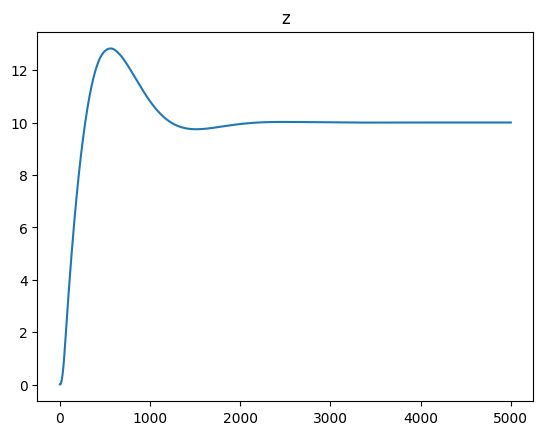

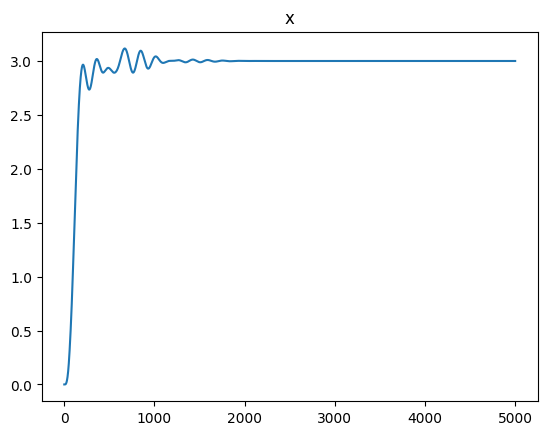

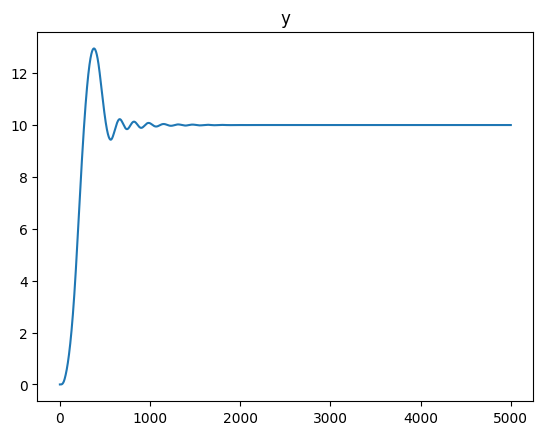

In [11]:
plt.title("z")
plt.plot(positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()